# Sea ice seasonality in the Southern Ocean
This script calculates days of sea ice advance, retreat, and total sea ice duration over the sea ice season (February 15 to February 14) in the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-21.10` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#Loading and manipulating data
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import calendar
from glob import glob
import os
import re
from dask.distributed import Client, progress
import geopandas
import string
from itertools import cycle
import cftime
import xesmf as xe
import rioxarray
import scipy.stats as ss

#Analysis module
import ZonalStatsFunctions as zsf

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import geopandas
#Show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

## Parallelising work
Start a cluster that uses multiple cores to parallelise work. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [2]:
client = Client(n_workers = 12)

## Setting up variables to access ACCESS-OM2-01 model outputs

Create a Cosima Cookbook session to access databases

In [26]:
session = cc.database.create_session()

A list of experiment outputs available through the Cosima Cookbook can be accessed using `cc.querying.get_experiments(session)`. Use the argument `all = True` to get a detailed list of available experiments.  
Variables included in each experiment can be obtained through `cc.querying.get_variables(session, experiment, frequency)`.

In [3]:
varDict =  {'var_id': 'aice',
            'model': 'ACCESS-OM2-01',
            'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
            'freq': '1 daily',
            'start_date': range(1965, 2018, 1),
            'offset': np.nan,
            'long_name': 'sea ice seasonality',
            'short_name': 'SIS',
            'unit': 'days',
            'CICE_data': True,
            'climatologies': r'/g/data/v45/la6889/Calculations/SI_seasons/Climatologies',
            'clim_fig': r'/g/data/v45/la6889/Figures/SI_seasons/Climatologies',
            'linear_trends': r'/g/data/v45/la6889/Calculations/SI_seasons/LinearTrends',
            'std_err': r'/g/data/v45/la6889/Calculations/SI_seasons/Std_Errors',
            'lm_fig': r'/g/data/v45/la6889/Figures/SI_seasons/LinearTrends',
            'clipped_data': r'/g/data/v45/la6889/Calculations/SI_seasons/ClippedMEASOregions/',
            'year_fig': r'/g/data/v45/la6889/Figures/SI_seasons/Yearly',
            'yearly': r'/g/data/v45/la6889/Calculations/SI_seasons/Yearly',
            'decadal': r'/g/data/v45/la6889/Calculations/SI_seasons/Decades',
            'anomalies': r'/g/data/v45/la6889/Calculations/SI_seasons/Anomalies',
            'decades': range(1965, 2019, 10),
            'res': '0.1°'}

## Sea ice season calculations

### From model outputs

In [6]:
#Defining path where calculations will be saved
dir_out = varDict['yearly']

#Applying calculation for every year
for yr in varDict['start_date']:
    #Loading daily ice data
    SO = zsf.getACCESSdata(varDict['var_id'], str(yr), str(yr+1), 
                           freq = varDict['freq'], ses = session,
                           minlat = -90, maxlat = -45, exp = varDict['expt'], 
                           ice_data = True)
    SO = zsf.corrlong(SO)
    #Calculate sea ice seasons
    adv, ret, sea = zsf.SeaIceAdvArrays(array = SO, dir_out = dir_out)
    del SO, adv, ret, sea

### From observations

In [ ]:
#Location of observation-based sea ice concentration
fileList = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Location where output files will be saved
dir_out = r'/g/data/v45/la6889/Observations/SIS'

#Load observational data
iceObs = [xr.open_dataarray(f) for f in fileList]
iceObs = xr.concat(iceObs, dim = 'time')

#Calculate sea ice seasons and store in disk
for yr in varDict['start_date']:
    obs = iceObs.sel(time = slice(str(yr), str(yr+1)))
    zsf.SeaIceAdvArrays(obs, dir_out = dir_out)

## Loading previously calculated seasons to avoid recalculations

### Model

In [6]:
#Location of files
mod_file = sorted(glob(os.path.join(varDict['yearly'], '*.nc')))

#Get list of files
adv = [xr.open_dataarray(f) for f in mod_file if 'Adv' in f]
ret = [xr.open_dataarray(f) for f in mod_file if 'Ret' in f]
dur = [xr.open_dataarray(f) for f in mod_file if 'Dur' in f]

#Save them in a dictionary
mod = {}
mod['advance'] = xr.concat(adv, dim = 'time')
mod['retreat'] = xr.concat(ret, dim = 'time')
mod['duration'] = xr.concat(dur, dim = 'time')

### Observations

In [7]:
#Location of files
obs_file = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/*.nc'))

#Get list of files
adv = [xr.open_dataarray(f) for f in obs_file if 'Adv' in f]
ret = [xr.open_dataarray(f) for f in obs_file if 'Ret' in f]
dur = [xr.open_dataarray(f) for f in obs_file if 'Dur' in f]

#Save them in a dictionary
obs = {}
obs['advance'] = xr.concat(adv, dim = 'time')
obs['retreat'] = xr.concat(ret, dim = 'time')
obs['duration'] = xr.concat(dur, dim = 'time')

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

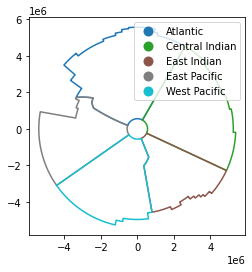

In [7]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

## Comparing model and observations

### Regridding model outputs to match observations (coarsening data) and calculating differences

In [31]:
#Rename coordinates in observation based and model based SIC
#Empty list tofilelistre renamed model data
model_prep = {}
obs_prep = {}

#Rename coordinates to match observations
for key in mod:
    #Cropping model outputs between 50S and 90S
    model_prep[key] = mod[key].sel(time = slice('1979', '2017')).\
    rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}).\
    sel(lat = slice(-90, -50))
    #Renaming coordinates from observations prior to regridding
    obs_prep[key] = obs[key].sel(time = slice('1979', '2017')).\
    rename({'longitude': 'lon', 'latitude': 'lat'})

In [26]:
#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(model_prep[key], obs_prep[key], 'bilinear')

#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['climatologies'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty list to store regridded model data, climatologies and biases
seasonal_clim_mod = {}
seasonal_clim_obs = {}
clim_dif = {}
reg_mod = {}

#Apply regridder
for key in model_prep:
    reg_mod[key] = reg_coarse(model_prep[key])
    reg_mod[key]['ygrid'] = obs_prep[key].ygrid
    reg_mod[key]['xgrid'] = obs_prep[key].xgrid
    fn = f'SISeasons_regridded-mod_{key}_1979-2018.nc'
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))
    #Calculate seasonal climatologies SIC and transform to percentages
    seasonal_clim_mod[key] = reg_mod[key].mean('time')
    seasonal_clim_obs[key] = obs_prep[key].mean('time')
    #Calculate differences in SIC
    clim_dif[key] = seasonal_clim_mod[key]-seasonal_clim_obs[key]

## Defining seasons

In [8]:
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

In [11]:
#Checking minimum and maximum values per SI season
for i in clim_dif:
    print(clim_dif[i].min().values, clim_dif[i].max().values)

## Plotting sea ice seasons

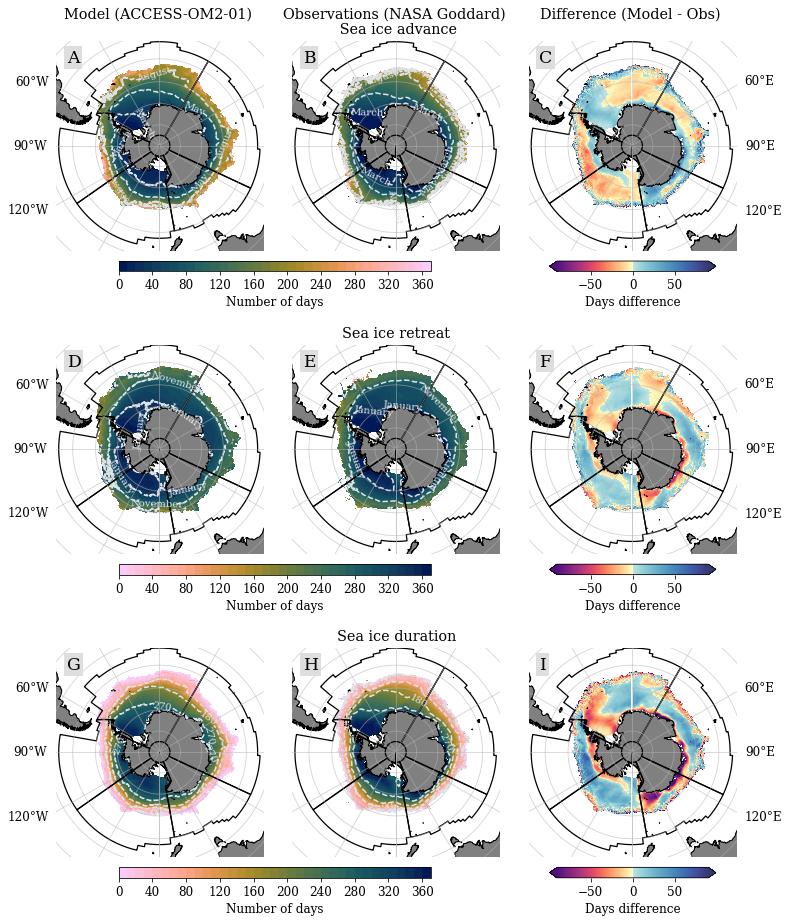

In [28]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -90, vcenter = 0, vmax = 90)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'batlow', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

data = ['Model (ACCESS-OM2-01)', 
        'Observations (NASA Goddard)',
        'Difference (Model - Obs)']

counter = zip(cycle(data), np.repeat(list(seasonNames), len(data)))
    
#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonNames),
                       ncols = len(data))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.45)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, coord in enumerate(counter):  
    ax[i] = fig.add_subplot(gs[i], 
                            projection = ccrs.SouthPolarStereo())
    model = mod[coord[1]].sel(time = slice('1979', '2017')).mean('time')
    obser = obs[coord[1]].sel(time = slice('1979', '2017')).mean('time')
    if coord[1] == 'advance':
        cmap = roma
    else:
        cmap = roma_r
    
    #Extract information for each season and start plotting
    if 'ACCESS' in coord[0]:
        p1 = model.plot.pcolormesh(ax = ax[i], cmap = cmap, 
                                  transform = ccrs.PlateCarree(),
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = model.plot.contour(levels = [29, 90, 182], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = model.plot.contour(levels = [274, 335], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = model.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed',
            transform = ccrs.PlateCarree())
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
        axins = inset_axes(ax[i], # here using axis of the first plot
                   width="150%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.3, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)
        cb = fig.colorbar(p1, orientation = 'horizontal', 
                      cax = axins, label = 'Number of days')
        
    #Observational data
    elif 'NASA' in coord[0]:
        p2 = obser.plot.pcolormesh(ax = ax[i], cmap = cmap,
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = obser.plot.contour(levels = [29, 90, 182],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = obser.plot.contour(levels = [274, 335],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = obser.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
    else:
        #Remove zeroes
        da_d = clim_dif[coord[1]].where(clim_dif[coord[1]] != 0)
        #Plot data
        p3 = da_d.plot(x = 'lon', y = 'lat', ax = ax[i], 
                       cmap = mymap, norm = divnorm,
                       transform = ccrs.PlateCarree(),
                       add_colorbar = False)
        axins2 = inset_axes(ax[i], # here using axis of the first plot
                   width="80%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.1, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)

        cb2 = fig.colorbar(p3, cax = axins2, extend = 'both',
                      orientation = 'horizontal',
                      label = 'Days difference')
   
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[i])
    
     #Set title for each map
    if i < 3 and 'NASA' in coord[0]:
        ax[i].set_title(f'{coord[0]} \n {seasonNames[coord[1]]}', y = 1.01)
    elif i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    elif i > 3 and 'NASA' in coord[0]:
        ax[i].set_title(seasonNames[coord[1]], y = 1.01)
        
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    
    #Set map extent
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.xlabels_top = False
    if i in [0, 3, 6]:
        gl.xlabels_left = True
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [1, 4, 7]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i in [2, 5, 8]:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.ylabels_bottom = False
        gl.xlabels_bottom = False
        gl.xlabels_right = True
    elif i == 9:
        gl.xlabels_left = True
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 10:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 11:
        gl.xlabels_left = False
        gl.ylabels_left = False
        gl.xlabels_bottom = True
        gl.xlabels_right = True
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:12]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

fn = 'MapSeaIceSeasonal_Climatology_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in sea ice seasonality

In [14]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results = {}

#Calculating linear trend for each season
for season in mod:
    model = mod[season].sel(time = slice('1979', '2017'))
    #Define file name
    fn = f'LinearTrend_SIS_{season}_1979-2017.nc'
    
    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(model.time))
    #Extract values from SIC data and create a vector
    vals = model.values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(model[0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = model.xt_ocean.values, 
                                        yt_ocean = model.yt_ocean.values),
                          name = "std_err")

    LM_results[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [12]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Linear*1979*.nc'))

LM_results = {}

for season in seasonNames:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

## Plotting seasonal trends

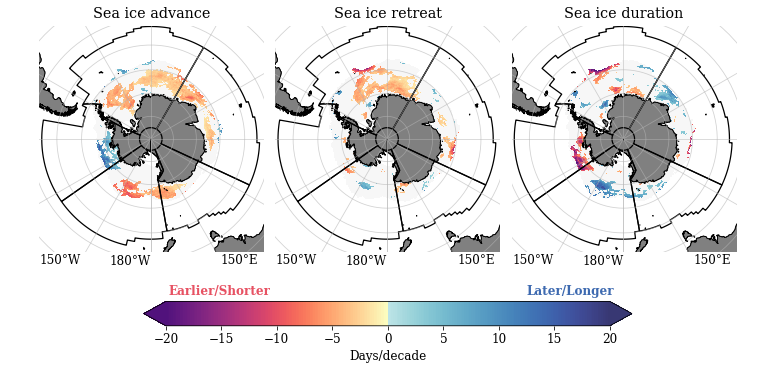

In [74]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))
#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -20, vcenter = 0, vmax = 20)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1,
                       ncols = len(seasonNames))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.45)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, season in enumerate(seasonNames):  
    ax[i] = fig.add_subplot(gs[i], 
                            projection = ccrs.SouthPolarStereo())
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err

    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 

    #Multiplying by 1000 to get percentages per decade
    p1 = (data*10).where(data != 0).\
    plot.pcolormesh(ax = ax[i], cmap = mymap, transform = ccrs.PlateCarree(),
                    norm = divnorm, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[i], 
                       transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[i])

    #Set title for each subplot.
    ax[i].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    
    #Set map extent
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 9
    gl.ypadding = 9
    gl.ylabels_bottom = True
    gl.xlabels_top = False
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]
    
#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
              orientation = 'horizontal', 
              shrink = 0.7, pad = 0.06, extend = 'both',
              label = 'Days/decade')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(12.5, 1.25, 'Later/Longer', color = mymap(0.85), fontweight = 'bold')
cb.ax.text(-19.75, 1.25, 'Earlier/Shorter', color = mymap(0.25), fontweight = 'bold')

fn = 'SeasonalLinearTrends_SeaIceSeasonality_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Calculating yearly mean values for SIS per sector

In [5]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

In [121]:
#Select the correct time frame: 1979-2017
for key in mod:
    mod[key] = zsf.corrlong(mod[key].sel(time = slice('1979', '2017')))
    obs[key] = obs[key].sel(time = slice('1979', '2017'))

## Splitting data into MEASO regions

In [11]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

In [12]:
#Loading mask
regions = xr.load_dataarray('MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

## Clipping longitude corrected data arrays

In [123]:
#Ensuring output folder exists
out_file = varDict['clipped_data']
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIS = {}

#Saving each sector as an entry in the dictionary
for season in mod:
    for sector in sectorNames:
        clipped_SIS[f"{sector}_{season}"] = mod[season]*MEASOregions[sector]
        clipped_SIS[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].rename(season)
        clipped_SIS[f"{sector}_{season}"].to_netcdf(os.path.join(out_file, ('SeaIce-' + sector + '_' + season + '-1979-2018.nc')))

In [92]:
#Removing variables no longer needed
del regions

### Loading data from disk to avoid calculating again

In [13]:
#Clipped data location
out_file = sorted(glob(os.path.join(varDict['clipped_data'], '*.nc')))

#Creating an empty dictionary to load data
clipped_SIS = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in out_file if sec in file]
    #Loop through each season within each sector
    for sea in mod:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).\
        sel(yt_ocean = slice(-90, -50))
        if sec != 'West Pacific':
            clipped_SIS[f'{sec}_{sea}'] = clipped_SIS[f'{sec}_{sea}'].\
            dropna('xt_ocean', how = 'all')

In [12]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
SIS_weighted = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    area_reg = IceArea*MEASOregions[sector]
    #Prepare volume data to be used as weights
    area_reg.name = 'weights'
    #Replace NA values with zeroes
    area_reg = area_reg.fillna(0)
    for season in mod:
        SIS_weighted[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].\
        weighted(area_reg)
        #Saving weighted means per sector (lon, lat)
        SIS_weighted[f"{sector}_{season}"] = SIS_weighted[f"{sector}_{season}"].\
        mean(('xt_ocean', 'yt_ocean'))

### Plotting yearly means with rolling decadal means
Colourblind palettes were chosen from [https://personal.sron.nl/~pault/#sec:qualitative].

In [17]:
#Create a dictionary to set colors that will be used to represent each sector in all figures
col = ["#4477aa", "#66ccee", "#228833", "#ccbb44", "#ee6677"]
colors = dict(zip(sectorNames, col))

advance Atlantic 0.07647255006144182 -1.894789408428873
advance Central Indian 0.00021057172307606647 -2.6659727984707704
advance East Indian 0.1450882108116723 -1.8535613099988892
advance West Pacific 0.7933416557560256 -0.37451994775534597
advance East Pacific 0.0626623574820245 4.292425992445872
retreat Atlantic 0.32738370742633893 -0.850377330054425
retreat Central Indian 0.9399757039710419 -0.04285629762450422
retreat East Indian 0.543347912571875 -0.7970028274263541
retreat West Pacific 0.8345116607277574 -0.3019693198657212
retreat East Pacific 0.9434303826363027 0.1505370929824756
duration Atlantic 0.5000997513752623 0.9626746680705625
duration Central Indian 0.004705764680624084 2.59528726021649
duration East Indian 0.5421048381342527 1.0751392454218898
duration West Pacific 0.9747170293312314 0.06511682267882311
duration East Pacific 0.036867261989350905 -4.332407890090021


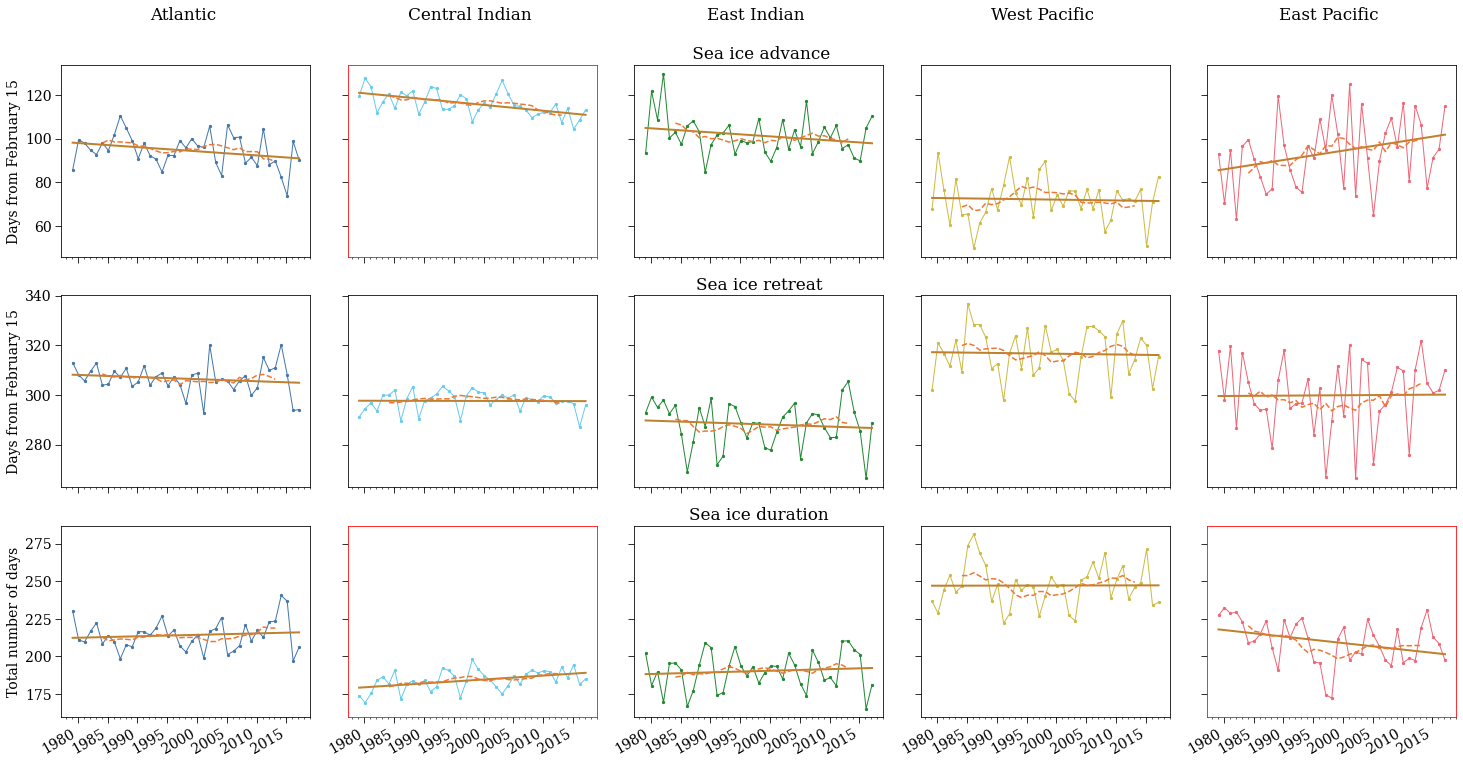

In [20]:
#Maximum and minimum values for the years when plotting    
maxV = SIS_weighted['Atlantic_advance'].indexes['time'].year.max()
minV = SIS_weighted['Atlantic_advance'].indexes['time'].year.min()

#Initialise figure
fig = plt.figure(figsize = (25, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = 3, ncols = 1)

#Creating subgrid per row (sea ice seasons)
for i, season in enumerate(seasonNames):
    #Create a list to hold axes information for every row. Each row will contain the same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain the same amount of plots as there are sectors. Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                                 subplot_spec = gs[i], wspace = 0.15)
    
    #Plotting figures in each grid cell (row wise)
    for j, sec in enumerate(sectorNames):
        #Initilise figures in each grid cell. Ensure x and y axes are shared across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        data = SIS_weighted[f'{sec}_{season}']
        #Calculating yearly means per sector and per season, and plotting them
        data.plot(ax = ax, linewidth = 1, marker = 'o', markersize = 2.25, 
                  color = colors[sec])
        slope, inter, rval, pval, se = ss.linregress(data.time.dt.year.values, 
                                                     data.values)
        plt.plot(data.time.values, inter+(slope*data.time.dt.year.values), 
                 label = f'Trend line {sec} (p = {round(pval, 3)})', 
                 color = '#bf812d', linewidth = 2)
        #Calculate the rolling decadal mean per sector and season
        SIS_weighted[f'{sec}_{season}'].rolling(time = 10, center = True).\
        mean().dropna('time').plot(ax = ax, color = '#ee7733', linestyle = '--')
        #Remove x axis label
        ax.set_xlabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        #Specifying how figure titles should appear in each grid cell
        if season == 'advance' and sec == sectorNames[2]:
            ax.set_title(f'{sec} \n \n Sea ice {season}')
        elif season == 'advance' and sec != sectorNames[2]: 
            ax.set_title(f'{sec} \n \n')
        elif season != 'advance' and sec == sectorNames[2]:
            ax.set_title(f'Sea ice {season}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if season != 'duration':
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sec == sectorNames[0] and season != 'duration':
            ax.set_ylabel('Days from February 15')
        #The last row of the first column has a different axis title
        elif sec == sectorNames[0] and season == 'duration':
            ax.set_ylabel('Total number of days')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(labelleft = False) 
        print(season, sec, pval, slope*10)
        if pval < 0.05:
            for pos in ['top', 'bottom', 'right', 'left']:
                ax.spines[pos].set_edgecolor('red')

# fn = 'SeaIceTrends_MEASOsectors_' + str(minV) + '-' + str(maxV)

# #Saving final figure
# plt.savefig(os.path.join(varDict['lm_fig'], fn), dpi = 300, bbox_inches = 'tight', 
#             pad_inches = 0.05)

# Calculating anomalies from baseline period
The function `AnomCalc` calculates anomalies from a baseline period. It has the option to calculate standarised anomalies. It takes the following inputs:
- `array` which refers to the data array containing information for the period being compared to the baseline. It could include just one year or multiple years (decades)
- `clim_array` is a three dimensional array containing data over the baseline period from which anomalies will be calculated
- `std_anom` is a boolean variable that if set to `True` results in standarised anomalies being calculated  
  
The function provides one output, which is a data array containing the calculated anomalies.

In [10]:
def AnomCalc(array, clim_array, std_anom = False):
    '''
    Inputs:
    array - refers to a data array containing information for the period being compared to the baseline. It could include just one year or multiple years (decades)
    clim_array - three dimensional array containing data over the baseline period from which anomalies will be calculated
    std_anom - boolean variable that if set to True will result in standarised anomalies being calculated
      
    Outputs:
    Data array containing anomalies.
    '''
    
    #Calculate long term mean of array
    m_climarray = clim_array.mean('time')
    
    #Calculate mean of comparison array in case it includes more than one year
    if len(array.dims) > 2:
        m_array = array.mean('time')
    else:
        m_array = array
    
    #Calculate anomalies
    #Standarised anomalies
    if std_anom == True:
        s_climarray = clim_array.std('time')
        anom = (m_array - m_climarray)/s_climarray
    #Non-standarised anomalies
    elif std_anom == False:
        anom = m_array - m_climarray
    
    #Return anomalies
    return anom

## Calculating sea ice seasonality anomalies
Anomalies are calculated per year and per season from the baseline. The time period chosen to calculate long-term mean SST, which will serve as a baseline, is between 1979 and 2008 (first 30 years of satellite records).  

In [ ]:
#Get list of files for the baseline period: 1979-2008
#File path of folder containing netcdf files
filein = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/Yearly/'
#Years of interest
yrs = np.arange(1979, 2009)

adv_list, ret_list, dur_list = zsf.getFileList(filein, yrs)

In [ ]:
#Combine files contained in the above lists into a three dimensional data array
dir_out = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/BaselineCalculations/'
base_adv, base_ret, base_dur = [zsf.combineData(i, dir_out = dir_out)\
                 for i in [adv_list, ret_list, dur_list]]

### Yearly anomaly calculation

In [43]:
#Get list of files for period of interest: 1965-2018
#File path of folder containing netcdf files
filein = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/Yearly/'
#Years of interest
yrs = np.arange(1965, 2019)

adv_list, ret_list, dur_list = zsf.getFileList(filein, yrs)

In [13]:
dir_out = r'/g/data/v45/la6889/Figures/Maps/SeaIceSeasonality/Anomalies/Yearly/Standarised/'
    
adv = [xr.open_dataarray(i, autoclose = True) for i in adv_list]
ret = [xr.open_dataarray(i, autoclose = True) for i in ret_list]
dur = [xr.open_dataarray(i, autoclose = True) for i in dur_list]
    
for i in range(len(adv)):
    #Calculate anomalies
    a_adv = AnomCalc(adv[i], base_adv, std_anom = True)
    a_ret = AnomCalc(ret[i], base_ret, std_anom = True)
    a_dur = AnomCalc(dur[i], base_dur, std_anom = True)
    
    #Provide min and max year info
    MinY = re.split('_|\.|-', adv_list[i])[1]
    MaxY = re.split('_|\.|-', adv_list[i])[2]
    
    #Remove unused variables
    del adv, ret, dur
    
    SeaIceAdvMap(a_adv, a_ret, a_dur, dir_out, palette = 'roma', 
                 anom_std = True, MinY = MinY, MaxY = MaxY)

### Decadal anomaly calculations

In [24]:
#Load combined baseline netcdf files
base_adv = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/BaselineCalculations/SeaIceAdv_1979-2009.nc', autoclose = True)
base_ret = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/BaselineCalculations/SeaIceRet_1979-2009.nc', autoclose = True)
base_dur = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/BaselineCalculations/SeaIceDur_1979-2009.nc', autoclose = True)

In [19]:
#Get list of files for each decade between 1965 and 2018
#File path of folder containing netcdf files
filein = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/DecadeCalculations/'
#Years of interest
yrs = np.arange(1965, 2019)
#Apply function
adv_list, ret_list, dur_list = zsf.getFileList(filein, yrs)

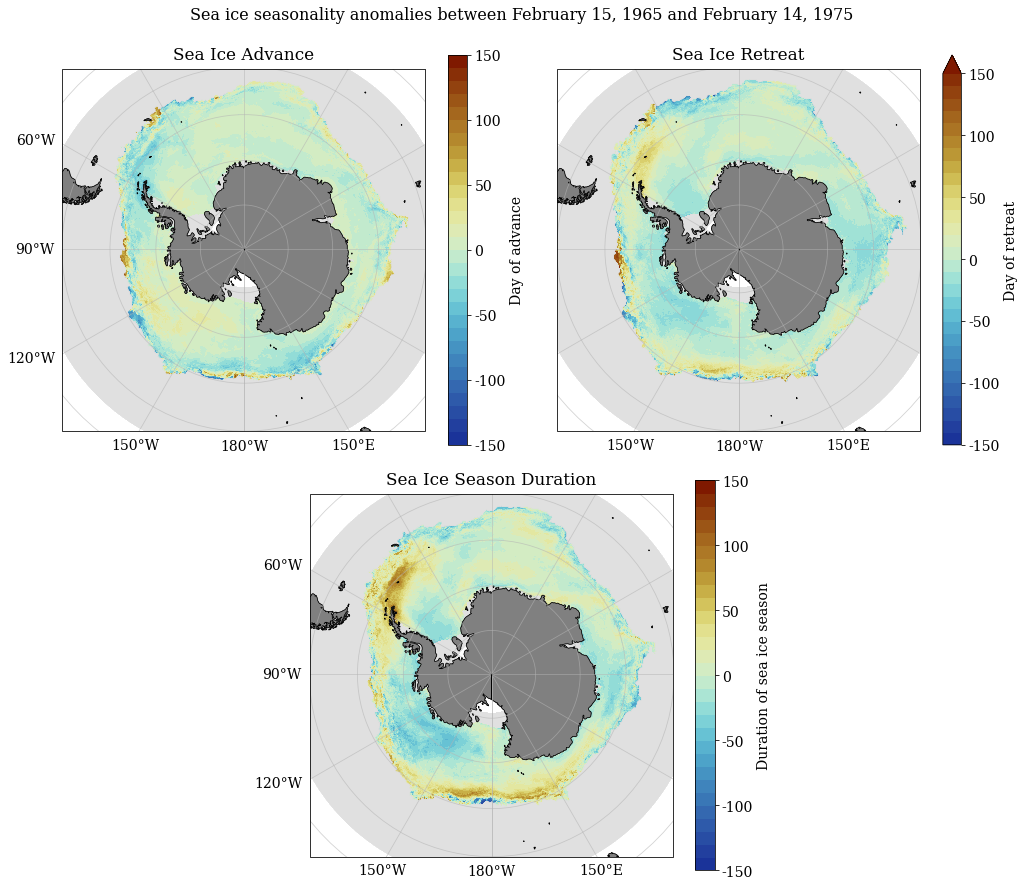

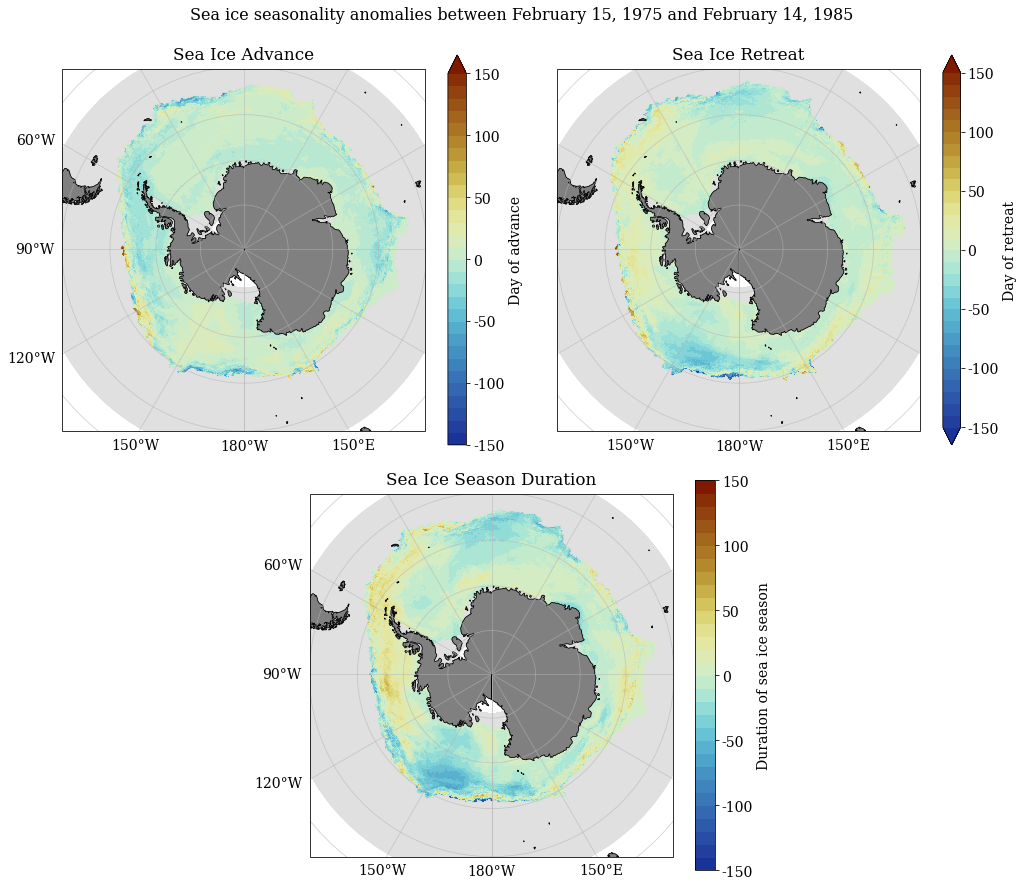

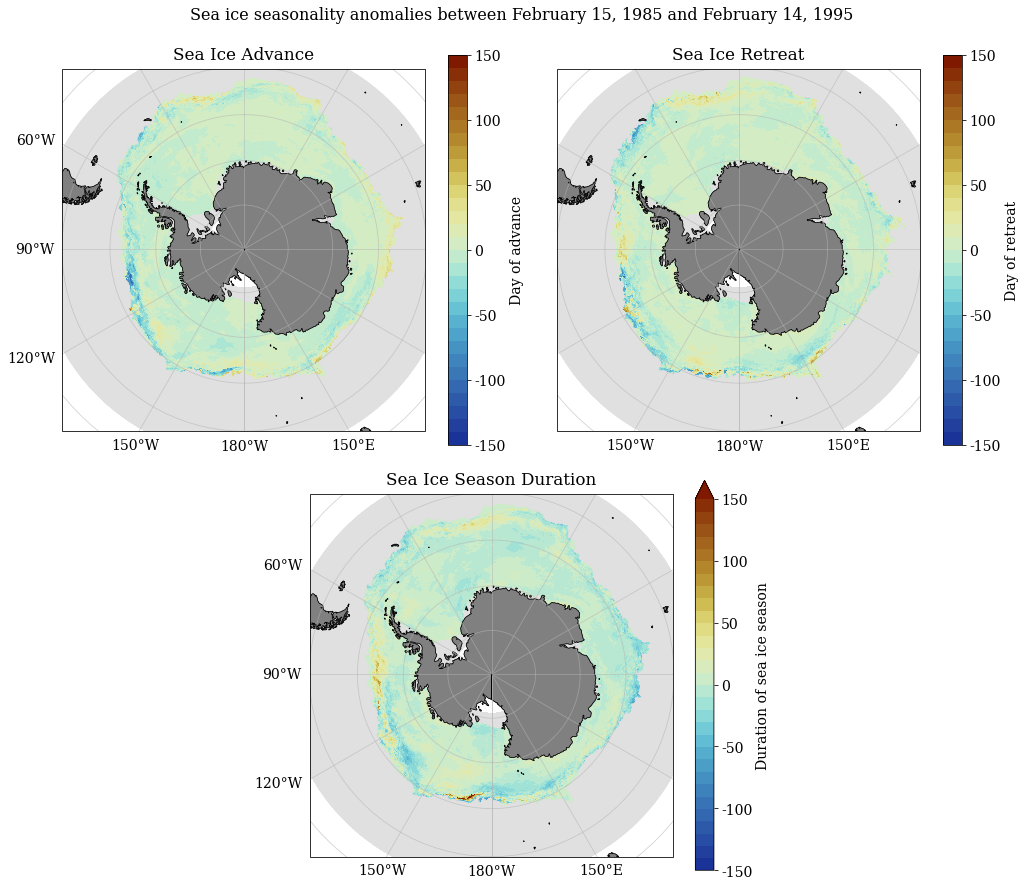

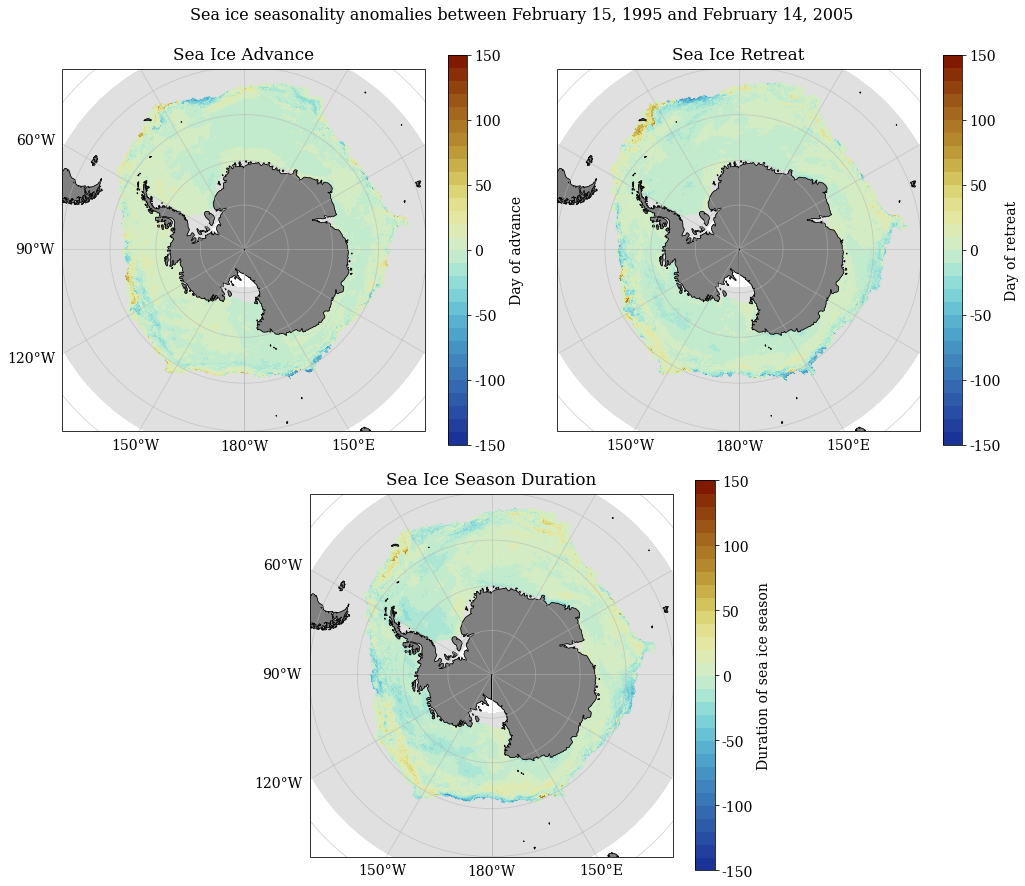

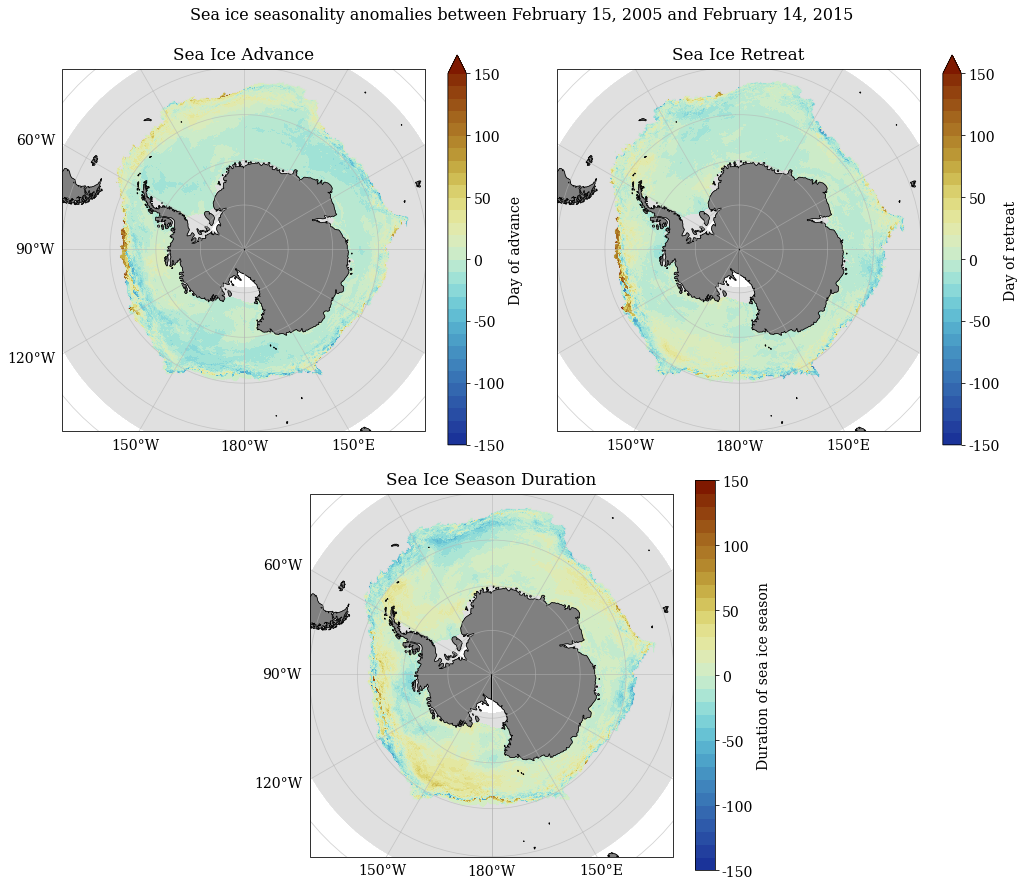

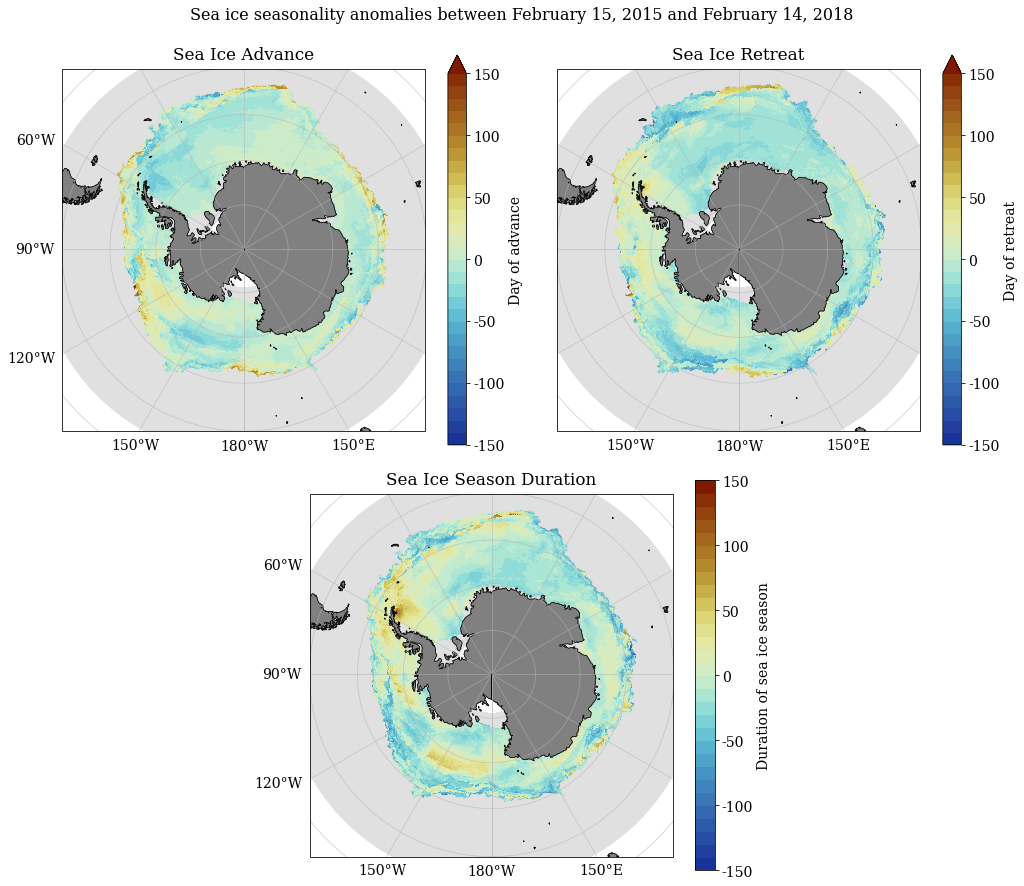

In [26]:
dir_out = r'/g/data/v45/la6889/Figures/Maps/SeaIceSeasonality/Anomalies/Decades/'

#Open yearly files
adv = [xr.open_dataarray(i, autoclose = True) for i in adv_list]
ret = [xr.open_dataarray(i, autoclose = True) for i in ret_list]
dur = [xr.open_dataarray(i, autoclose = True) for i in dur_list]

for i in np.arange(0, len(adv_list)):
    #Calculate anomalies
    a_adv = AnomCalc(adv, base_adv, std_anom = False)
    a_ret = AnomCalc(ret, base_ret, std_anom = False)
    a_dur = AnomCalc(dur, base_dur, std_anom = False)
    
    #Provide min and max year info
    MinY = re.split('_|\.|-', adv_list[i])[1]
    MaxY = re.split('_|\.|-', adv_list[i])[2]
    
    #Remove unused variables
    del adv, ret, dur
    
    SeaIceAdvMap(a_adv, a_ret, a_dur, dir_out, palette = 'roma', anom = True, MinY = MinY, MaxY = MaxY)

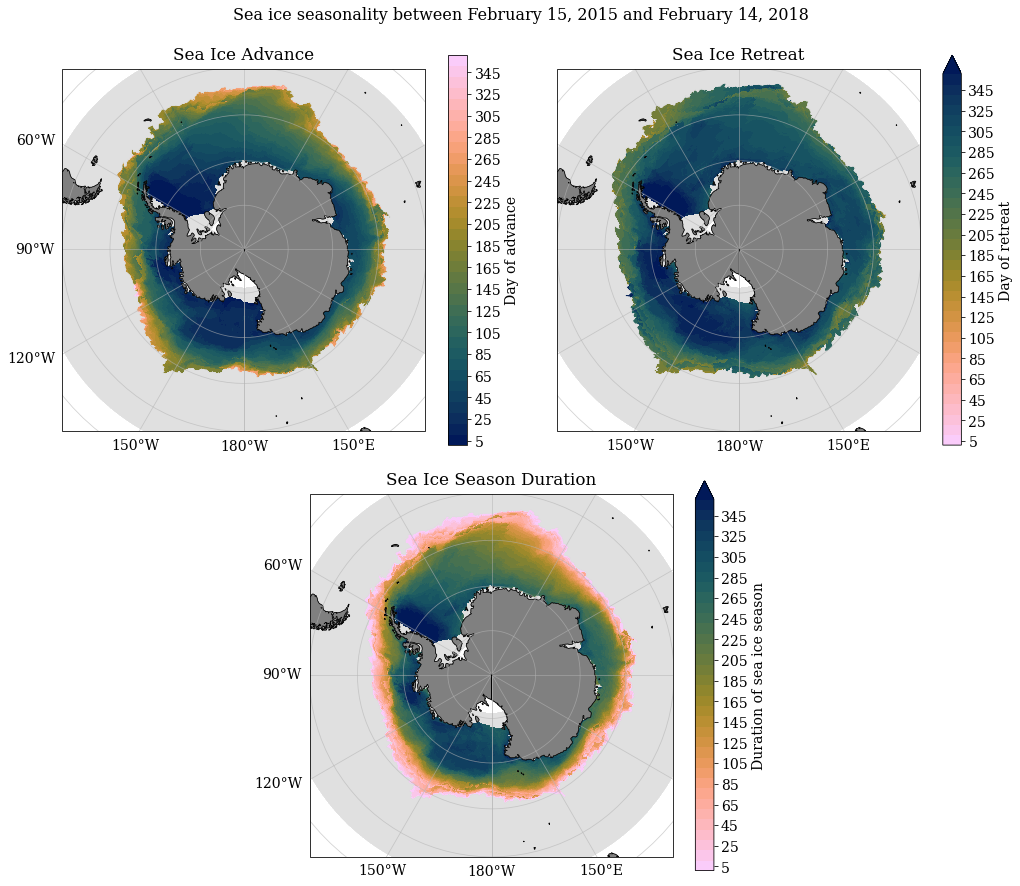

In [84]:
#Plotting means over time periods defined in previous step
SeaIceAdvMap(adv.mean('time'), ret.mean('time'), dur.mean('time'), yrs[0], yrs[-1]+1, palette = 'batlow')

### Calculating mean weighted sea ice seasonality values and comparing against unweighted means

The `weightedMeans` function takes three 3-dimensional data arrays to calculate weighted means over time:
- `adv` which contains sea ice advance data for multiple time steps
- `ret` which contains sea ice retreat data for multiple time steps
- `dur` which contains sea ice season duration data for multiple time steps  
  
Three outputs are given `adv_weighted_mean`, `ret_weighted_mean` and `dur_weighted_mean` which are 2-dimensional data arrays containing the weighted means calculated over time.

In [27]:
def weightedMeans(adv, ret, dur, dir_out):
    '''
    Inputs:
    adv refers to a data array that contains sea ice advance data for multiple time steps
    ret refers to a data array that contains sea ice retreat data for multiple time steps
    dur refers to a data array that contains sea ice season duration data for multiple time steps
      
    Outputs:
    Three outputs are given `adv_weighted_mean`, `ret_weighted_mean` and `dur_weighted_mean` which are 2-dimensional data arrays containing the weighted means calculated over time.
    '''
    
    #Minimum and maximum years
    MinY = str(adv.indexes['time'].year.min())
    MaxY = str(adv.indexes['time'].year.max())
    
    #Creating a variable with numbers of days within each year
    days = adv.time.dt.days_in_month
    #Change values to 366 if there are 29 days, otherwise change to 365
    days = xr.where(days == 29, 366, 365)
    #Calculate weights dividing each timestep to the total
    weights = days/days.sum()
    weights.name = "weights"
    #Remove variables not in use
    del days

    #Apply weights along time axis
    adv_weighted = adv.weighted(weights)
    ret_weighted = ret.weighted(weights)
    dur_weighted = dur.weighted(weights)

    #Calculate weighted means
    adv_weighted_mean = adv_weighted.mean('time')
    ret_weighted_mean = ret_weighted.mean('time')
    dur_weighted_mean = dur_weighted.mean('time')

    #Saving weighted means
    adv_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceAdvWeightedMean_'+ MinY +'-' + MaxY +'.nc')))
    ret_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceRetWeightedMean_'+ MinY +'-' + MaxY +'.nc')))
    dur_weighted_mean.to_netcdf(os.path.join(dir_out, ('SeaIceDurWeightedMean_'+ MinY +'-' + MaxY +'.nc')))

    #Remove variables not in use
    del adv_weighted, ret_weighted, dur_weighted, weights
    
    #Return weighted means
    return adv_weighted_mean, ret_weighted_mean, dur_weighted_mean

In [29]:
#Directory where all files will be saved
dir_out = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/BaselineCalculations/WeightedMeans/'

#Applying function to calculate weighted means
adv_w, ret_w, dur_w = weightedMeans(base_adv, base_ret, base_dur, dir_out)

# Sea ice seasonality calculations per sector
Once sea ice seasonality calculations have been performed for the entirety of the Southern Ocean, they can be further examined within smaller sections if boundaries are provided in the form of shapefiles.

## Loading relevant libraries

In [1]:
import ZonalStatsFunctions as zsf
import xarray as xr
import numpy as np
import pandas as pd
import geopandas
import os
from dask.distributed import Client
import re
import scipy.stats as ss
from xhistogram.xarray import histogram
from glob import glob

#Useful for plotting figures, including maps
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft

In [3]:
client = Client(n_workers = 12)

## Loading data arrays containing advance, retreat and total sea ice season duration

In [2]:
#Defining sea ice seasons
SI_seasons = ['advance', 'retreat', 'duration']

#Defining sector names in order
sectorNames = ['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific']

In [6]:
#Loading data
SI_data = {SI_seasons[0]: xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceAdv_1965-2018.nc'),
           SI_seasons[1]: xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceRet_1965-2018.nc'),
           SI_seasons[2]: xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceDur_1965-2018.nc')}

## Calculating trends in sea ice seasonality
Linear trends in sea ice seasonality over the entire study period over a particular study area (e.g., Southern Ocean, West Pacific region).

In [84]:
dir_out = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/LinearTrends'

for season in SI_seasons:
    #Extracting years to calculate linear trends
    yrs = SI_data[season].time.dt.year.values
    #Extract values from SI seasonality data and create a vector
    vals = SI_data[season].values.reshape(len(yrs), -1)
    
    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = yrs)
    
    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(SI_data[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = SI_data[season].xt_ocean.values, 
                                        yt_ocean = SI_data[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(SI_data[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = SI_data[season].xt_ocean.values, 
                                        yt_ocean = SI_data[season].yt_ocean.values),
                          name = "p_values")
    
    LM_results = xr.merge([coef_r, pval_r]).expand_dims({'season': [season]})
    
    #Ensure directory exists prior to saving results
    os.makedirs(dir_out, exist_ok = True)
    
    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, 
                                      (f'LinearTrend_SeaIce_{season}_{str(yrs.min())}-{str(yrs.max())}.nc')))

### Loading linear trends

In [199]:
#Loading data
SI_LTrends = {SI_seasons[0]: xr.open_dataset(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/LinearTrends/LinearTrend_SeaIce_advance_1965-2017.nc'),
              SI_seasons[1]: xr.open_dataset(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/LinearTrends/LinearTrend_SeaIce_retreat_1965-2017.nc'),
              SI_seasons[2]: xr.open_dataset(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/LinearTrends/LinearTrend_SeaIce_duration_1965-2017.nc')}

### Plotting maps with linear trends

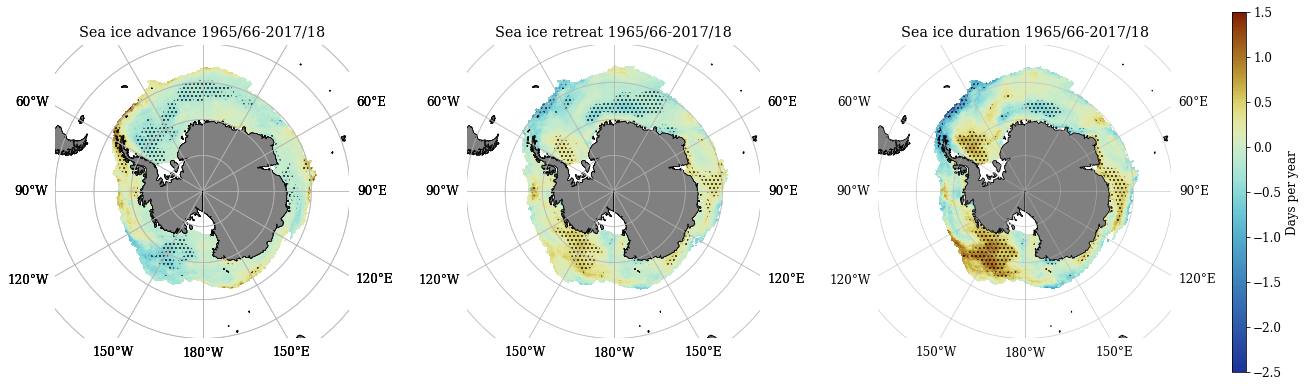

In [257]:
#Set color palette for trends to be centered at zero
divnorm = mcolors.TwoSlopeNorm(vmin = -2.5, vcenter = 0, vmax = 1.5)

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'roma', rev = True)
nuuk = zsf.colourMaps('../../ScientificColourMaps6/', 'nuuk', rev = False)

#Initialise figure
fig = plt.figure(figsize = (20, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1, ncols = len(SI_seasons))
#Change the width between each plot
gs.update(wspace = 0.4)

#Set up variable to contain axes
axs = {}

########
#Plot linear trends in sea ice seasons
for i in range(0, len(SI_seasons)):
    #Add subplots with linear trends 
    axs[SI_seasons[i] + 'trend'] = fig.add_subplot(gs[i], projection = projection)

    #Add contour plot of sea ice advance
    p = SI_LTrends[SI_seasons[i]].coefficients[0].plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', 
                                                                  ax = axs[SI_seasons[i] + 'trend'],
                                                                  #Setting color palette and contour levels
                                                                  cmap = roma_r, transform = ccrs.PlateCarree(), 
                                                                  add_colorbar = False,
                                                                  norm = divnorm)

    #Add subplots with statistical significance
    sig = xr.where(SI_LTrends[SI_seasons[i]].p_values[0] <= 0.05, True, np.nan)
    sig.plot.contourf(hatches = ['...'], colors = 'none', ax = axs[SI_seasons[i] + 'trend'], 
                      transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Add subplot title
    axs[SI_seasons[i] + 'trend'].set_title('Sea ice ' + SI_seasons[i] + ' 1965/66-2017/18', y = 1.01)
    
   
    #######
    #Set colourbars as an inset to last row only
    if i == (len(SI_seasons)-1):
        #Linear trends - width and height of the colourbar 
        cb_lt = inset_axes(axs[SI_seasons[i] + 'trend'], width = 0.2, height = 5, loc = 'right', 
                           #defining where the colourbar will appear (left, bottom, width, height)
                           bbox_to_anchor = (0.275, 0, 1, 1), 
                           bbox_transform = axs[SI_seasons[i] + 'trend'].transAxes)
        #Apply colourbar to figure and set it to be horizontal
        fig.colorbar(p, cax = cb_lt, label = 'Days per year')
        

    ######
    for ax in axs.values():
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.ylabels_left = True
        gl.ylabels_right = True
        gl.xlabels_top = False
        gl.ylabels_top = False
        gl.xlabels_bottom = True
        gl.ylabels_bottom = False
        #Remove outside border
        [s.set_visible(False) for s in ax.spines.values()]

#Ensure output folder exists
out_file = r'/g/data/v45/la6889/Figures/Maps/SeaIceSeasonality/LinearTrends'
os.makedirs(out_file, exist_ok = True)
#Saving final figure
plt.savefig(os.path.join(out_file, 'SeaIceSeasons_LinearTrends_1965-2018.png'), dpi = 300)

## Calculating yearly means per sector per sea ice season

In [166]:
#Specifying folder where calculations will be stored
out_folder = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/Yearly/Sectors'
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
mean_days_SIS = {}

#Saving each sector as an entry in the dictionary
for season in SI_seasons:
    for sector in sectorNames:
        mean_days_SIS[f'{sector}_{season}'] = clipped_SIS[f"{sector}_{season}"].groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
        #Saving calculations
        minY = mean_days_SIS[f'{sector}_{season}'].indexes['time'].year.min()
        maxY = mean_days_SIS[f'{sector}_{season}'].indexes['time'].year.max()
        mean_days_SIS[f'{sector}_{season}'].to_netcdf(os.path.join(out_folder, (f'SeaIce_{season}_{sector}_{minY}-{maxY}.nc')))

### Loading files to avoid calculating means again

In [12]:
#Point to the location of files
in_folder = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/Yearly/Sectors'
#Create a list of all files
file_list = os.listdir(in_folder)

#Create an empty dictionary that will contain all means
mean_days_SIS = {}

#Loop through seasons and sectors to 
for season in SI_seasons:
    for sector in sectorNames:
        for i in file_list:
            if (season in i) and (sector in i):
                mean_days_SIS[f'{sector}_{season}'] = xr.open_dataarray(os.path.join(in_folder, i))

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

## Calculating weighted yearly means

Accessing total area per pixel to perform weighted mean calculations.

### Plotting weighted yearly means

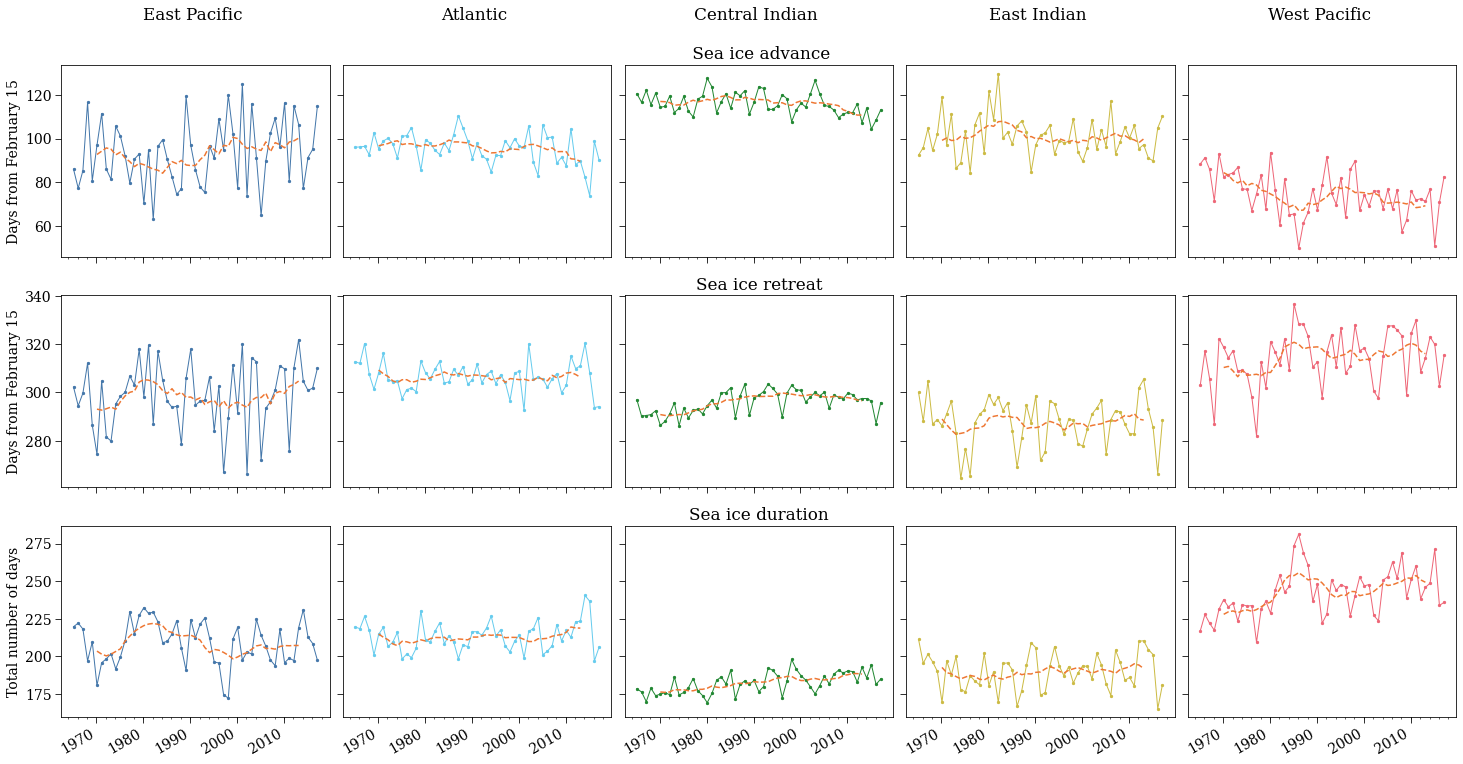

In [175]:
#Getting min and max years
minV = SIS_weighted['Atlantic_advance'].time.dt.year.values.min()
maxV = SIS_weighted['Atlantic_advance'].time.dt.year.values.max()

#Initialise figure
fig = plt.figure(figsize = (25, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = len(SI_seasons), ncols = 1)

#Creating subgrid per row (sea ice seasons)
for i in range(len(SI_seasons)):
    #Create a list to hold axes information for every row. Each row will contain the same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain the same amount of plots as there are sectors. Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames), subplot_spec = gs[i], wspace = 0.05)
    
    #Plotting figures in each grid cell (row wise)
    for j in range(len(sectorNames)):
        #Initilise figures in each grid cell. Ensure x and y axes are shared across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        #Calculating yearly means per sector and per season, and plotting them
        SIS_weighted[f'{sectorNames[j]}_{SI_seasons[i]}'].plot(ax = ax, linewidth = 1, marker = 'o', markersize = 2.25, color = colors[sectorNames[j]])
        #Calculate the rolling decadal mean per sector and season
        SIS_weighted[f'{sectorNames[j]}_{SI_seasons[i]}'].rolling(time = 10, center = True).mean().dropna('time').plot(ax = ax, color = '#ee7733', linestyle = '--')
        #Remove x axis label
        ax.set_xlabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        #Specifying how figure titles should appear in each grid cell
        if SI_seasons[i] == SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'{sectorNames[j]} \n \n Sea ice {SI_seasons[i]}')
        elif SI_seasons[i] == SI_seasons[0] and sectorNames[j] != sectorNames[2]: 
            ax.set_title(f'{sectorNames[j]} \n \n')
        elif SI_seasons[i] != SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'Sea ice {SI_seasons[i]}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if SI_seasons[i] != SI_seasons[-1]:
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sectorNames[j] == sectorNames[0] and SI_seasons[i] != SI_seasons[-1]:
            ax.set_ylabel('Days from February 15')
        #The last row of the first column has a different axis title
        elif sectorNames[j] == sectorNames[0] and SI_seasons[i] == SI_seasons[-1]:
            ax.set_ylabel('Total number of days')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(labelleft = False) 
            
#Saving final figure
plt.savefig(os.path.join('/g/data/v45/la6889/Figures/TimeSeries/SeaIceSeasonality', ('SeaIceTrendsWeighted_MEASOsectors_' + str(minV) + '-' + str(maxV))), dpi = 300)

## Calculating climatologies per sector

In [32]:
#Saving climatology
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Climatology/'

#Ensuring file exists
os.makedirs(out_file, exist_ok = True)

#Defining dictionaries where climatology and results will be stored
clim_SIS = {}

#Saving each sector as an entry in the dictionary
for season in SI_seasons:
    for sector in sectorNames:
        #Getting dataset to calculate climatology (from 1979 to 2008 - satellite period)
        clim_SIS[f'{sector}_{season}'] = clipped_SIS[f"{sector}_{season}"].\
        sel(time = slice('1979', '2008')).mean('time')
        #Saving climatologies
        clim_SIS[f'{sector}_{season}'].to_netcdf(os.path.join(out_file, f'Climatology_1979-2008_{sector}-{season}.nc'))

### Loading climatologies from disk to avoid calculating again

In [4]:
#Clipped data location
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Climatology/'

#Creating an empty dictionary to load data
clim_SIS = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(out_file) if os.path.isfile(os.path.join(out_file, f))])

#Creating joint counter for seasons, sectors and file names
names = []
[names.append(f'{sec}_{sea}') for sec, sea 
 in zip(np.repeat(sectorNames, len(SI_seasons)), (SI_seasons*len(sectorNames)))]

#Opening all files in a dictionary
for file, name in zip(files, sorted(names)):
    clim_SIS[f"{name}"] = xr.open_dataarray(os.path.join(out_file, file), autoclose = True)

### Loading Antarctica shape to include it in plots

In [4]:
#Location of Antartica files
in_file = r'/g/data/v45/la6889/GIS_DataBase/Antarctica_MEASO'

#Creating an empty dictionary to load data
Antarctica = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(in_file) if os.path.isfile(os.path.join(in_file, f))])

names = []
[names.append(f'{sec}') for sec in sectorNames]

#Opening all files in a dictionary
for file, name in zip(files, sorted(names)):
    Antarctica[f"{name}"] = xr.open_dataarray(os.path.join(in_file, file), autoclose = True)

## Calculating standardised anomalies per month and per season

### Loading SIS calculated from observations

In [5]:
file_obs = r'/g/data/v45/la6889/Observations/SIS/Transformed_SIS-Obs_wgs84/HighResolution/'
yrs = np.arange(1979, 2019)
adv, ret, dur = zsf.getFileList(file_obs, yrs)

obs = {}
obs['advance'] = zsf.combineData(adv)
obs['retreat'] = zsf.combineData(ret)
obs['duration'] = zsf.combineData(dur)

### Clipping SIS from observations using MEASO sectors

In [22]:
for season in SI_seasons:
    obs[season] = zsf.corrlong(obs[season].rename({'lon': 'xt_ocean', 'lat': 'yt_ocean'}))

#Saving clipped data
out_file = r'/g/data/v45/la6889/Observations/SIS/MEASOregions/'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIS_obs = {}

#Saving each sector as an entry in the dictionary
for season in SI_seasons:
    for sector in sectorNames:
        clipped_SIS_obs[f"{sector}_{season}"] = obs[season]*MEASOregions[sector]
        clipped_SIS_obs[f"{sector}_{season}"] = clipped_SIS_obs[f"{sector}_{season}"].rename(season)
        clipped_SIS_obs[f"{sector}_{season}"].to_netcdf(os.path.join(out_file, ('SeaIce-' + sector + '_' + season + '-1965-2018.nc')))

### Loading observational data from disk to avoid calculating again

In [6]:
#Getting a list of nc files inside the folder containing the clipped data
in_files = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS_obs = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in in_files if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS_obs[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS_obs[f'{sec}_{sea}'] = clipped_SIS_obs[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

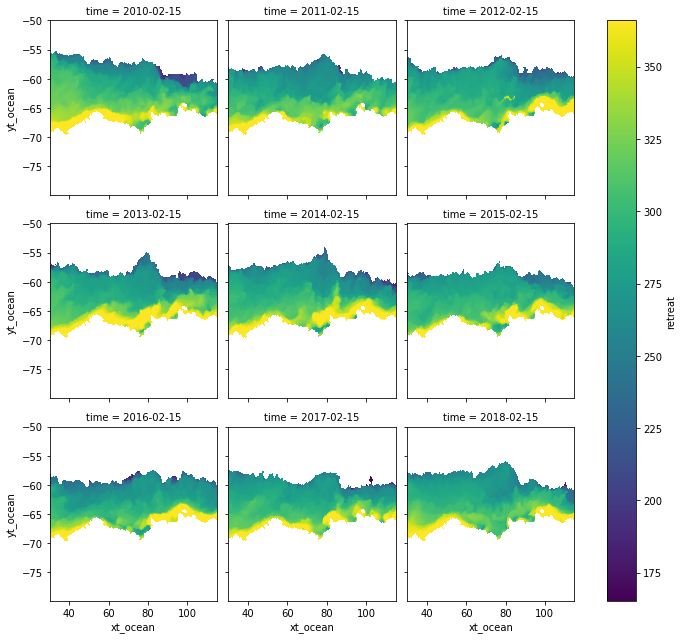

In [10]:
clipped_SIS_obs['Central Indian_retreat'].sel(time = slice('2010', '2018')).plot(col = 'time', col_wrap = 3)

### Clip dataset containing area per pixel to apply as weights

In [52]:
#Loading ocean area to create weights
import cosima_cookbook as cc
session = cc.database.create_session()
area =  cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'area_t', session, frequency = 'static', n = -1)

#Select data for the Southern Ocean only
area = area.sel(yt_ocean = slice(-90, -45))

#Apply longitude correction
area = zsf.corrlong(area)

#Save result
area.to_netcdf('/g/data/v45/la6889/Calculations/area_per_pixel_01deg.nc')

#Clipping data
#Define folder where clipped data will be saved
out_file = r'/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/MEASOsectors'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_area = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    #Create a mask using model and observational data
    reg_mod = xr.where(~np.isnan(clipped_SIS[f'{sector}_advance'].sum('time', skipna = True, min_count = 1)), True, np.nan)
    reg_obs = xr.where(~np.isnan(clipped_SIS_obs[f'{sector}_advance'].sum('time', skipna = True, min_count = 1)), True, np.nan)
    #Apply mask matching each sector
    clipped_area[f'{sector}_mod'] = area*reg_mod
    clipped_area[f'{sector}_obs'] = area*reg_obs
    clipped_area[f'{sector}_mod'].to_netcdf(os.path.join(out_file, f'area_per_pixel_01deg_{sector}_mod.nc'))
    clipped_area[f'{sector}_obs'].to_netcdf(os.path.join(out_file, f'area_per_pixel_01deg_{sector}_obs.nc'))

### Loading areas to be applied as weights
If areas have been clipped, simply load results and avoid reclipping

In [11]:
#Get all files ending in .nc in the folder containing clipped areas
file_area = sorted(glob(r'/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/MEASOsectors/*.nc'))

#Initialise dictionary to store data
clipped_area = {}

#Load data
for sec in sectorNames:
    mod_files = [file for file in file_area if f'{sec}_mod' in file]
    obs_files = [file for file in file_area if f'{sec}_obs' in file]
    clipped_area[f'{sec}_mod'] = xr.open_dataarray(mod_files[0], autoclose = True)
    clipped_area[f'{sec}_obs'] = xr.open_dataarray(obs_files[0], autoclose = True)

### Loading Antarctica shape to include it in plots

In [115]:
#Location of Antartica files
in_file = r'/g/data/v45/la6889/GIS_DataBase/Antarctica_MEASO'

#Creating an empty dictionary to load data
Antarctica = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(in_file) if os.path.isfile(os.path.join(in_file, f))])

names = []
[names.append(f'{sec}') for sec in sectorNames]

#Opening all files in a dictionary
for file, name in zip(files, sorted(names)):
    Antarctica[f"{name}"] = xr.open_dataarray(os.path.join(in_file, file), autoclose = True)

### Plotting anomalies in sea ice seasons

In [67]:
def plotAnom(obs, mod, **kwargs):
    #Initialising figure
    fig = plt.figure(figsize = (15, 5))

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Create a grid inside the figure with seasons defining the number of rows and one column
    gs = gridspec.GridSpec(ncols = len(SI_seasons), nrows = 1)
    gs.update(wspace = 0.3)
    
    for i, sea in enumerate(SI_seasons):
        ax = fig.add_subplot(gs[i])
        #Plotting histogram for SIS from models
        mod[sea].plot(color = 'green', linestyle = '--', linewidth = 1,
                  label = 'model', ax = ax)
        #Plotting histogram for SIS from observations
        obs[sea].plot(color = 'blue', label = 'observations', linewidth = 1, ax = ax)
        ax.axhline(y = 0, color = 'black', linestyle = '--')
        ax.axhline(y = 2, color = 'black')
        ax.axhline(y = -2, color = 'black')
        ax.set_title(f'{SI_seasons[i].title()}')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included
        #between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
        ax.set_xlabel('')
        ax.set_ylabel('')
        if i == 0:
            ax.set_ylabel('Standarised anomaly')
        elif i == 2:
            ax.legend(loc = 'upper center')
    
    reg = str(obs.region.values)
    fig.suptitle(f'Sea ice {sea} standarised anomaly in {reg} sector', y = 1.01)

    #Saving figure
    if 'out_folder' in kwargs.keys():
        #Ensuring folder exists
        os.makedirs(kwargs.get('out_folder'), exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_folder'), f'StdAnom_{reg}_1965-2017.png'), 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

[None, None, None, None, None]

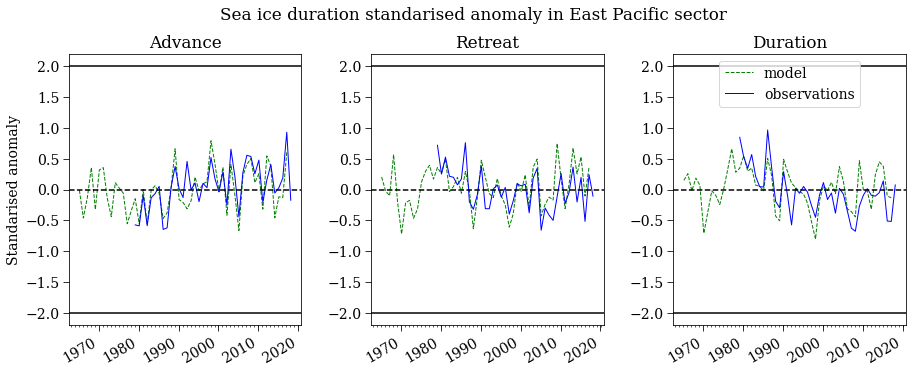

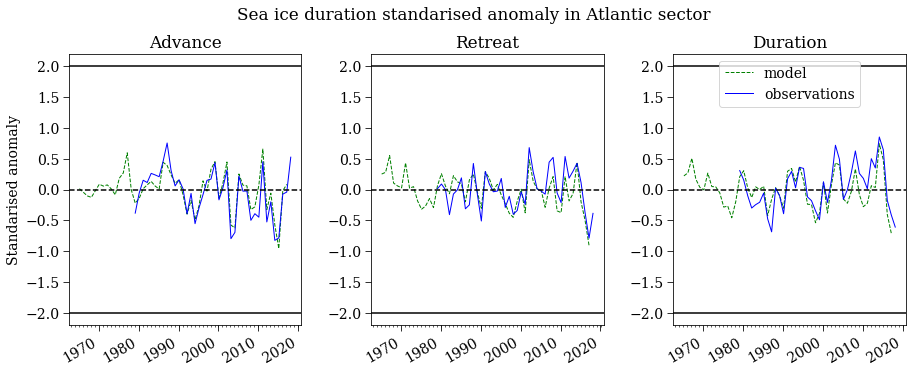

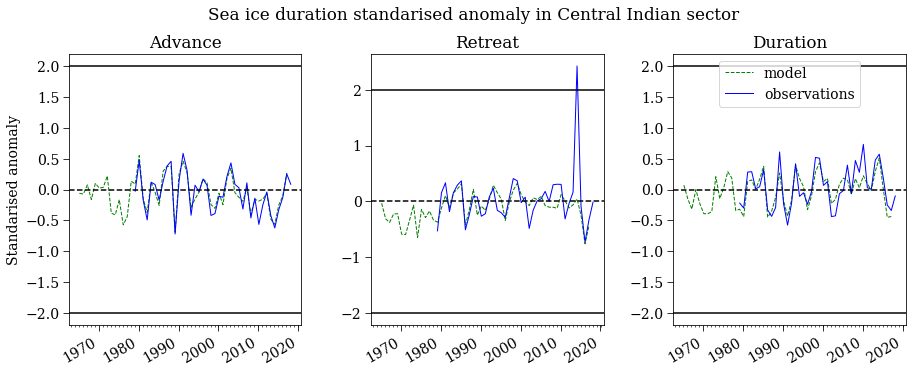

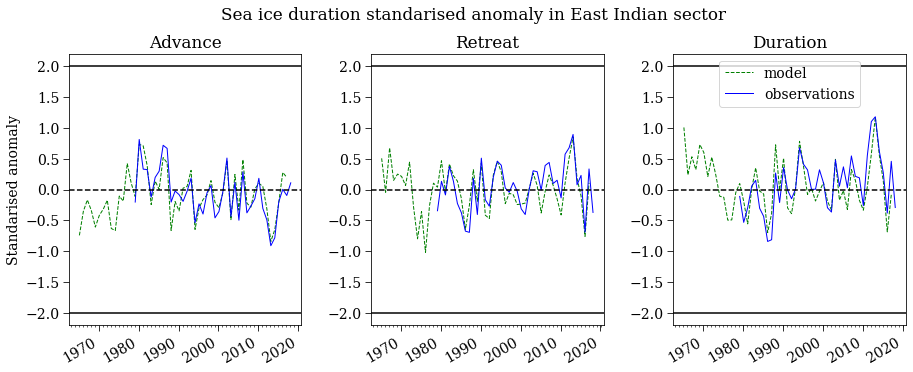

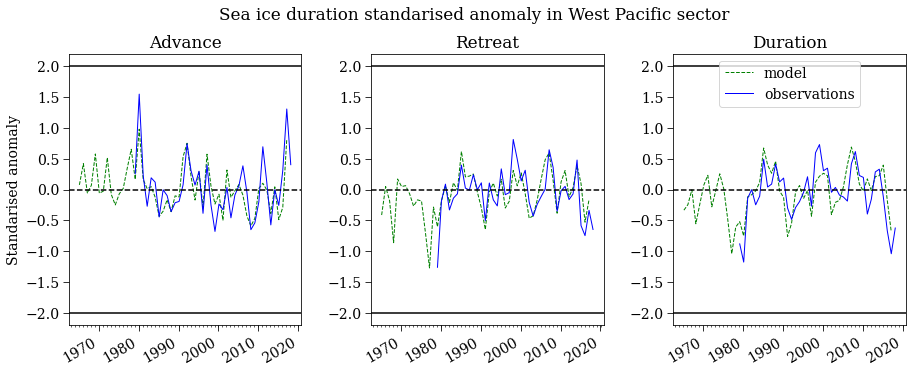

In [68]:
#Folder where figures will be saved
out_folder = r'/g/data/v45/la6889/Figures/TimeSeries/SeaIceSeasonality/StdAnomalies'
#Apply plotting function
[plotAnom(yearly_clim[f'{sec}_obs'], yearly_clim[f'{sec}_mod'], 
          out_folder = out_folder) for sec in sectorNames]

## Calculating yearly latitudinal means per sector per sea ice season

### Checking distance along the longitudinal axis of a pixel

In [21]:
area =  cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'area_t', session, frequency = 'static', n = -1)
area = area.sel(yt_ocean = slice(-90, -45))
area

<xarray.DataArray 'area_t' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

Pixel distance along longitude is the same for all pixels. Distance only changes along latitude, so no weighting has been applied prior to the creation of Hovmoller diagrams.

In [ ]:
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Latitudes'
os.makedirs(out_file, exist_ok = True)
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
mean_lat_SIS = {}

#Saving each sector as an entry in the dictionary
for season in SI_seasons:
    for sector in sectorNames:
        mean_lat_SIS[f'{sector}_{season}'] = clipped_SIS[f"{sector}_{season}"].mean('xt_ocean')
        mean_lat_SIS[f'{sector}_{season}'].to_netcdf(os.path.join(out_file, f'MeanLatitudeSIS_{sector}-{season}_1965-2018.nc'))

### Loading data from disk to avoid calculating again

In [4]:
#Clipped data location
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Latitudes/'

#Creating an empty dictionary to load data
mean_lat_SIS = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(out_file) if os.path.isfile(os.path.join(out_file, f))])

#Creating joint counter for seasons, sectors and file names
names = []
[names.append(f'{sec}_{sea}') for sec, sea 
 in zip(np.repeat(sectorNames, len(SI_seasons)), (SI_seasons*len(sectorNames)))]

#Opening all files in a dictionary
for file, name in zip(files, sorted(names)):
    mean_lat_SIS[f"{name}"] = xr.open_dataarray(os.path.join(out_file, file), autoclose = True)

### Hovmoller plots of latitudinal means over time

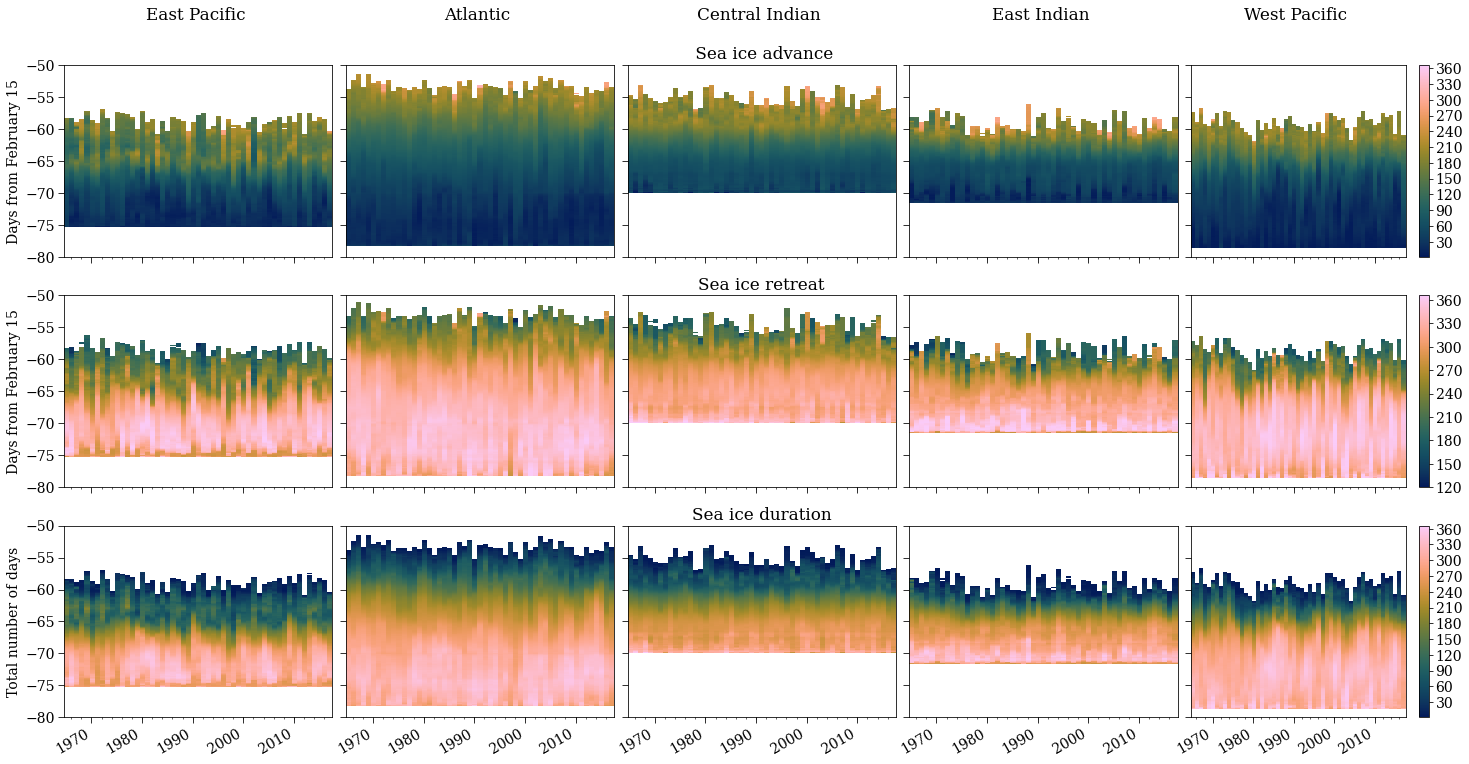

In [179]:
#Initialise figure
fig = plt.figure(figsize = (25, 12))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = len(SI_seasons), ncols = 1)

#Setting limits for the range of values shown in colorbar
vmin = [1, 120, 1]
vmax = [366]*3

#Getting min and max years
minV = mean_lat_SIS['Atlantic_advance'].time.dt.year.values.min()
maxV = mean_lat_SIS['Atlantic_advance'].time.dt.year.values.max()

#Creating subgrid per row (sea ice seasons)
for i in range(len(SI_seasons)):
    #Create a list to hold axes information for every row. Each row will contain the same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain the same amount of plots as there are sectors. Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames), subplot_spec = gs[i], wspace = 0.05)
    
    #Plotting figures in each grid cell (row wise)
    for j in range(len(sectorNames)):
        #Initilise figures in each grid cell. Ensure x and y axes are shared across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        
        #Calculating yearly means per sector and per season, and plotting them
        p = mean_lat_SIS[f'{sectorNames[j]}_{SI_seasons[i]}'].plot(y = 'yt_ocean', x = 'time', ax = ax, cmap = batlow, vmin = vmin[i], vmax = vmax[i], add_colorbar = False)
        #Remove x axis label
        ax.set_xlabel('')
        ax.set_ylim(-80, -50)
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        #Colorbar shown only for the last column
        if j == 4 and i != 1:    
            cb = plt.colorbar(p)
            cb.set_label('')
            cbar_ticks = range(0, vmax[i], 30)
        elif j == 4 and i == 1:
            cb = plt.colorbar(p)
            cb.set_label('')
            cbar_ticks = range(vmin[i], vmax[i], 30)
        cb.set_ticks(cbar_ticks)
        #Specifying how figure titles should appear in each grid cell
        if SI_seasons[i] == SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'{sectorNames[j]} \n \n Sea ice {SI_seasons[i]}')
        elif SI_seasons[i] == SI_seasons[0] and sectorNames[j] != sectorNames[2]: 
            ax.set_title(f'{sectorNames[j]} \n \n')
        elif SI_seasons[i] != SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'Sea ice {SI_seasons[i]}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if SI_seasons[i] != SI_seasons[-1]:
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sectorNames[j] == sectorNames[0] and SI_seasons[i] != SI_seasons[-1]:
            ax.set_ylabel('Days from February 15')
        #The last row of the first column has a different axis title
        elif sectorNames[j] == sectorNames[0] and SI_seasons[i] == SI_seasons[-1]:
            ax.set_ylabel('Total number of days')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(labelleft = False) 

#Saving climatology
out_file = r'/g/data/v45/la6889/Figures/Hovmoller/SeaIceSeasonality'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)       
            
#Saving final figure
plt.savefig(os.path.join(out_file, ('SeaIceTrendsLatitude_MEASOsectors_' + str(minV) + '-' + str(maxV))), dpi = 300)

## Calculating simple linear regression along sample latitudes
Linear trends are investigated along five latitudes starting at -75S and finishing at -55S. 

In [5]:
#Folder where outputs will be saved
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Trends/'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)

#Creating a list of the latitudes of interest
lats = np.arange(-75, -50, 5)
#Creating an empty dictionary to hold the results of linear regressions over five latitudes
lat_trends = {}

#Loop through sectors and seasons
for sec in sectorNames:
    #Creating empty lists to hold intermediate results
    sec_split = sorted([i for i in mean_lat_SIS.keys() if sec in i])
    sec_deck = []
    for nam, sea in zip(sec_split, sorted(SI_seasons)):
        #Select the closest latitudes of interest from the mean latitudinal dataset  
        sub = mean_lat_SIS[f'{nam}'].drop('region').sel(yt_ocean = lats,
                                               #Change NA values to zeroes
                                               method = 'nearest')
        #Calculate linear regression
        l_reg = zsf.lm_lats(sub, lats)
        #Stack up all seasons per region in one dataset
        sec_deck.append(l_reg.expand_dims({'season': [sea]}))
    #Merge all seasons per sector into one data array and save as one entry 
    #in the dictionary
    lat_trends[f'{sec}'] = xr.concat(sec_deck, dim = 'season')
    lat_trends[f'{sec}'].to_netcdf(os.path.join(out_file, 
                                                f'LinearRegressions_{sec}_1965-2018'))

#Removing variables no longer needed
del sec_deck, sec_split

### Loading files to avoid calculating again

In [4]:
#Clipped data location
in_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/Trends/'

#Creating an empty dictionary to load data
lat_trends = {}

#Getting a list of files inside the folder. All folders are removed
files = sorted([f for f in os.listdir(in_file) if os.path.isfile(os.path.join(in_file, f))])

#Opening all files in a dictionary
for file, name in zip(files, sorted(sectorNames)):
    lat_trends[f"{name}"] = xr.open_dataset(os.path.join(in_file, file), autoclose = True)

In [7]:
def PlotLinLatTrend(array, sector, **kwargs):
    '''
    Inputs:
    array - Data array containing the data to be plotted
    sector - Name of the sector from which the data comes from
    
    Optional:
    out_file - Refers to the path of the folder where plots will be saved
    '''
    
    #Creating a list of latitudes to be plotted
    lats = array.yt_ocean.values
    #List of labels to be used for the y axis
    labels_seasons = ['Days from February 15', 'Days from February 15', 'Total number of days']

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Initialising figure
    fig, axs = plt.subplots(len(SI_seasons), len(lats), sharex = True, figsize = (15, 10), sharey = 'row')
    
    for row in range(len(SI_seasons)):
        for col in range(len(lats)):
            #Plotting model data
            array.model_data.sel(season = SI_seasons[row]).sel(yt_ocean = lats[col],
                                                  method = 'nearest').\
            plot(color = "#1b9e77", ax = axs[row, col])
            #Plotting predictions
            array.predictions.sel(season = SI_seasons[row]).sel(yt_ocean = lats[col],
                                                  method = 'nearest').\
            plot(color = "#d95f02", ax = axs[row, col], linestyle = "--")
            
            
            intercept = round(array.intercept.sel(season = SI_seasons[row]).\
                  sel(yt_ocean = lats[col], method = 'nearest').values.tolist(), 3)
            slope = round(array.slope.sel(season = SI_seasons[row]).\
                          sel(yt_ocean = lats[col], method = 'nearest').values.tolist(), 3)
            p = round(array.p_val.sel(season = SI_seasons[row]).\
                          sel(yt_ocean = lats[col], method = 'nearest').values.tolist(), 3)
            if np.isfinite(intercept):
                eq = f'{SI_seasons[row]} = {intercept} + ({slope} * year), \n p-value = {p}'                
            else:
                eq = ''
                    
            axs[row, col].set_title('')
            if p > 0.05:
                axs[row, col].set_xlabel(f'\n\n{eq}', fontsize = 'x-small')
            else:
                axs[row, col].set_xlabel(f'\n\n{eq}', fontsize = 'x-small', fontweight = 'bold')
            axs[row, col].set_ylabel('')
            #Increasing the size of the x and y axes ticks
            axs[row, col].tick_params(length = 6)
            # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair 
            axs[row, col].xaxis.set_minor_locator(AutoMinorLocator(n = 5))

    #Setting y labels for the first column only
    [axs[i, 0].set_ylabel(f'Sea ice {j} \n {k}') for i, j, k in zip(range(len(SI_seasons)), SI_seasons, labels_seasons)]
    #Setting titles for first row only
    [axs[0, i].set_title(f'Latitude: \n {round(j, 0)}') for i, j in enumerate(lats)]
    
    #Adding the sector as title
    plt.suptitle(sector)
    fig.align_ylabels(axs[:])
    fig.tight_layout()
    
    #Saving figures
    if 'out_file' in kwargs.keys():
        os.makedirs(out_file, exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_file'), f'LatitudinalLinearTrend_{sector}_1965-2018.png'), dpi = 300)

[None, None, None, None, None]

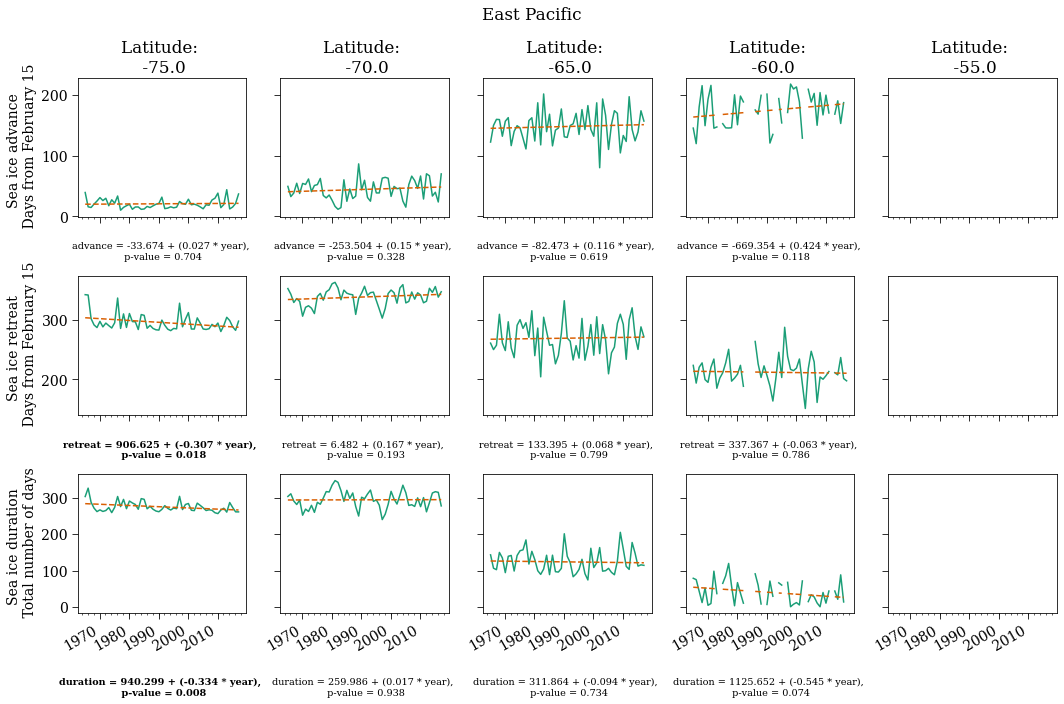

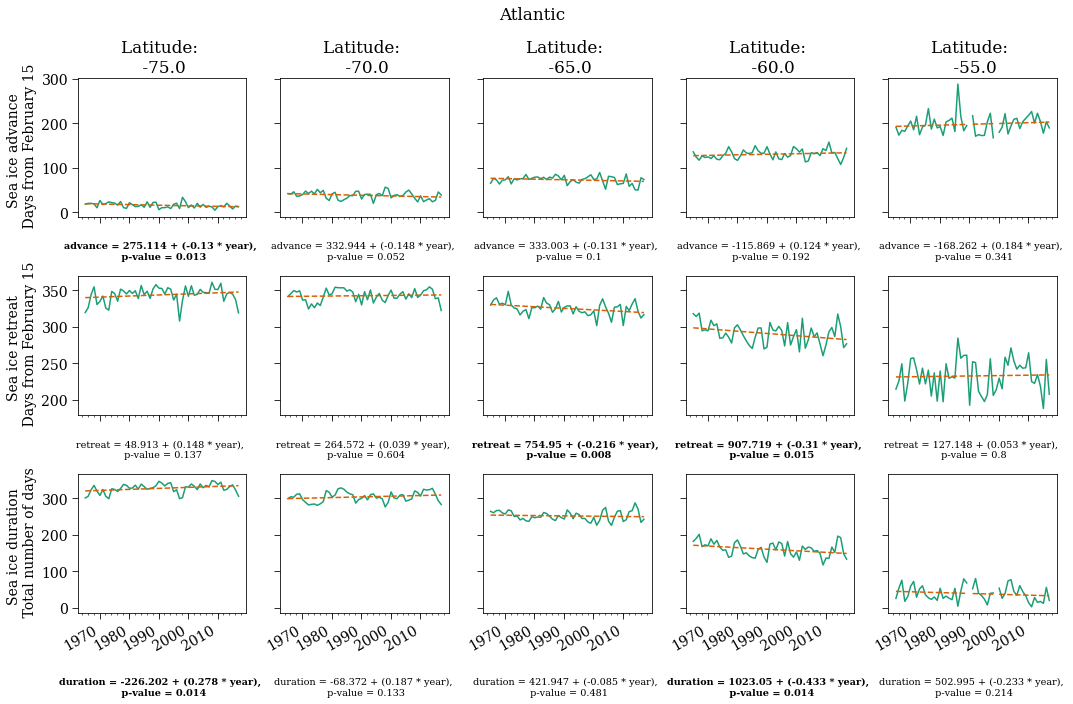

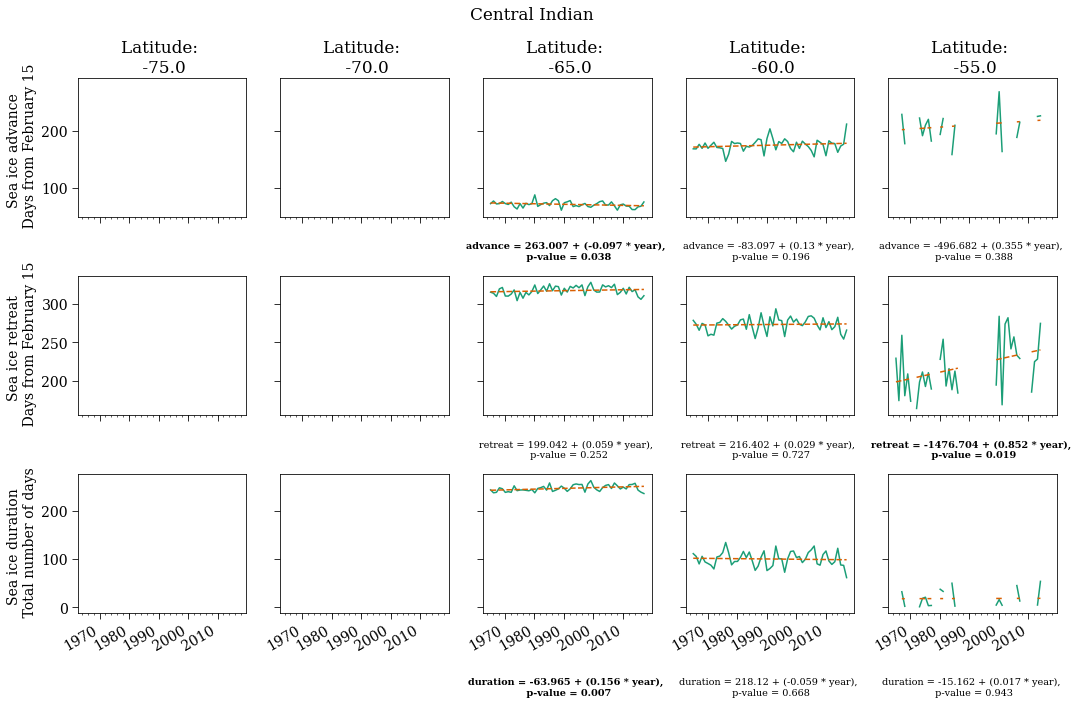

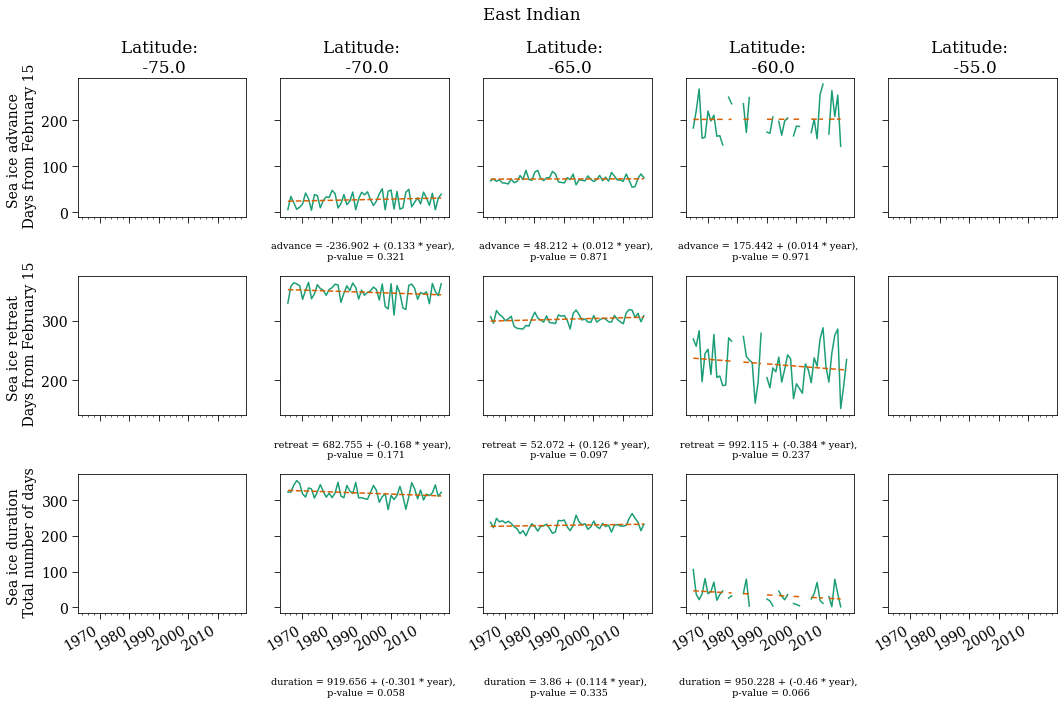

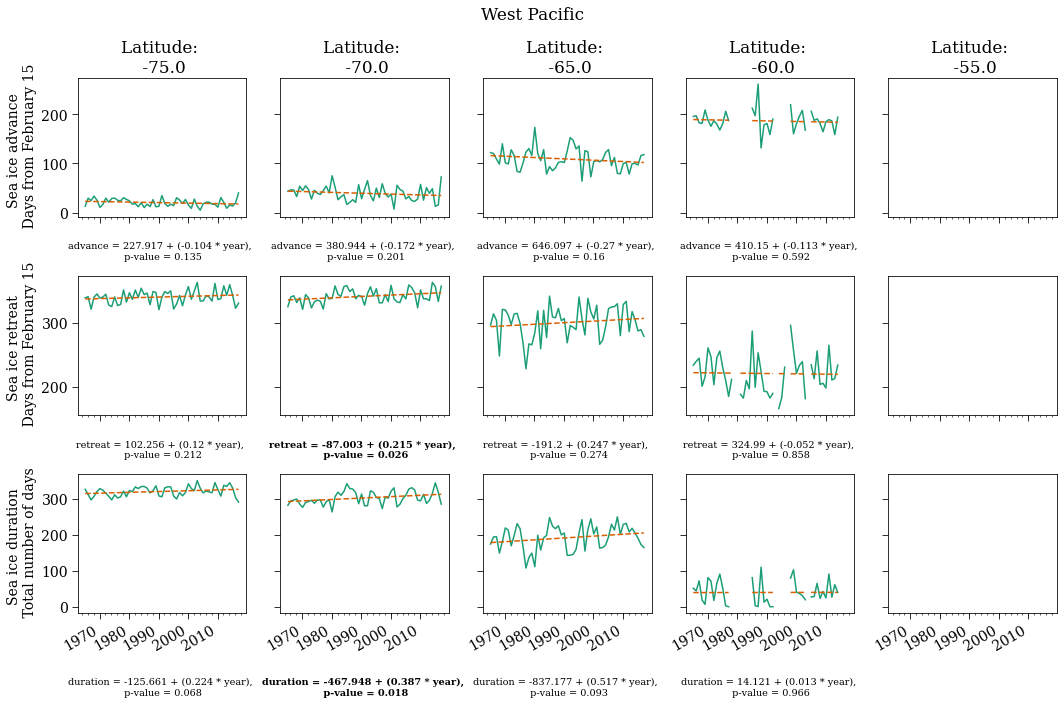

In [9]:
out_file = r'/g/data/v45/la6889/Figures/TimeSeries/SeaIceSeasonality/MEASO'
[PlotLinLatTrend(lat_trends[f'{sec}'], sec, out_file = out_file) for sec in sectorNames]

## Probability density function
Comparing sea ice seasons (SIS) calculated from model outputs and observations

### Loading clipped SIS from observations
In case data has already been clipped.

In [103]:
#Getting a list of nc files inside the folder containing the clipped data
in_files = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS_obs = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in in_files if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS_obs[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS_obs[f'{sec}_{sea}'] = clipped_SIS_obs[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

### Loading areas to be applied as weights
If areas have been clipped, simply load results and avoid reclipping

In [98]:
#Load area per pixel for Southern Ocean
area = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg.nc')

#Initialise dictionary to store data
clipped_area = {}

#Extract weights for each sector
for sec in sectorNames:
    mod = []
    obs = []
    for sea in SI_seasons:
        mod_data = clipped_SIS[f'{sec}_{sea}'].sum('time', skipna = True, min_count = 1)
        obs_data = clipped_SIS_obs[f'{sec}_{sea}'].sum('time', skipna = True, min_count = 1)
        m = area.where(~np.isnan(mod_data))
        m.name = sea
        o = area.where(~np.isnan(obs_data))
        o.name = sea
        mod.append(m)
        obs.append(o)
        clipped_area[f'{sec}_mod'] = xr.merge(mod)
        clipped_area[f'{sec}_obs'] = xr.merge(obs)

In [105]:
data_pdf = {}
for sec in sectorNames:
    keys = [key for key in clipped_SIS.keys() if sec in key]
    keys_weights = [key for key in clipped_area.keys() if sec in key]
    mod = []
    obs = []
    for sea in SI_seasons[:-1]:
        sea_key = [key for key in keys if sea in key]
        mod.append(clipped_SIS[sea_key[0]])
        obs.append(clipped_SIS_obs[sea_key[0]])
    data_pdf[f'{sec}_mod'] = xr.merge(mod)
    data_pdf[f'{sec}_obs'] = xr.merge(obs)

### Weighted Probability Density Function

In [60]:
def plot_weightedPDF(obs, mod, bins, weights_obs, weights_mod, **kwargs):  

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14
    #Stacking data and apply
    pdf_mod = {}
    pdf_obs = {}
    for sea in SI_seasons[0:2]:        
        #Models
        mod_int = mod[sea].sel(time = slice('1979', '2017'))
        s_mod = mod_int.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_mod = ~np.isnan(s_mod)
        #Save masked data
        masked_mod = s_mod[mask_mod]
        #Get weights for model data
        w_mod = weights_mod[sea].broadcast_like(mod_int)
        s_weight = w_mod.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        weight_model = s_weight[mask_mod]
        
        #Observations
        obs_int = obs[sea].sel(time = slice('1979', '2017'))
        s_obs = obs_int.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_obs = ~np.isnan(s_obs)
        masked_obs = s_obs[mask_obs]
        #Get weights for observations
        w_obs = weights_obs[sea].broadcast_like(obs_int)
        m_weight = w_obs.stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        weight_obs = m_weight[mask_obs]      
        
        #Calculating KDEs
        #Models
        kde_mod = ss.gaussian_kde(masked_mod, weights = weight_model)
        pdf_mod[f'{sea}'] = kde_mod(bins)
        #Observations
        kde_obs = ss.gaussian_kde(masked_obs, weights = weight_obs)
        pdf_obs[f'{sea}'] = kde_obs(bins)
        
    #Initialising figure
    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot(111)
    
    #Plotting data
    ax.plot(bins, pdf_obs['advance'], color = '#004488', linewidth = 1, 
            label = 'advance - observations')
    ax.plot(bins, pdf_obs['retreat'], color = '#BB5566', linewidth = 1, 
            label = 'retreat - observations')
    ax.plot(bins, pdf_mod['advance'], color = '#004488', label = 'advance - model', 
            linewidth = 1, linestyle = 'dashed')
    ax.plot(bins, pdf_mod['retreat'], color = '#BB5566', label = 'retreat - model', 
            linewidth = 1, linestyle = 'dashed')
    #Increasing the size of the x and y axes ticks
    ax.tick_params(length = 6)
    # For the minor ticks, use no labels; five minor ticks to be included
    #between each major tick pair 
    ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
    ax.set_xlabel('Number of days from February 14')
    ax.legend(loc = 'upper center')
    reg = str(obs.region.values)
    fig.suptitle(f'Probability density for sea ice season metrics in the {reg} sector (1979-2017)',
                 y = 1.01)

    #Saving figure
    if 'out_folder' in kwargs.keys():
        #Ensuring folder exists
        os.makedirs(kwargs.get('out_folder'), exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_folder'), f'PDFs-weighted_{reg}_1979-2017.png'), 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

[None, None, None, None, None]

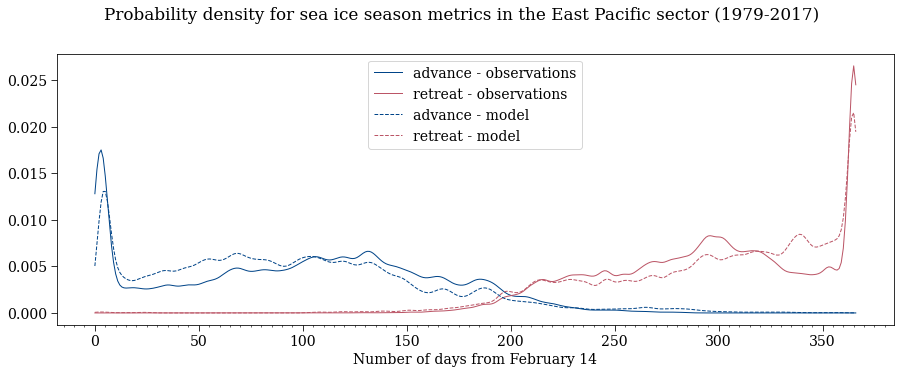

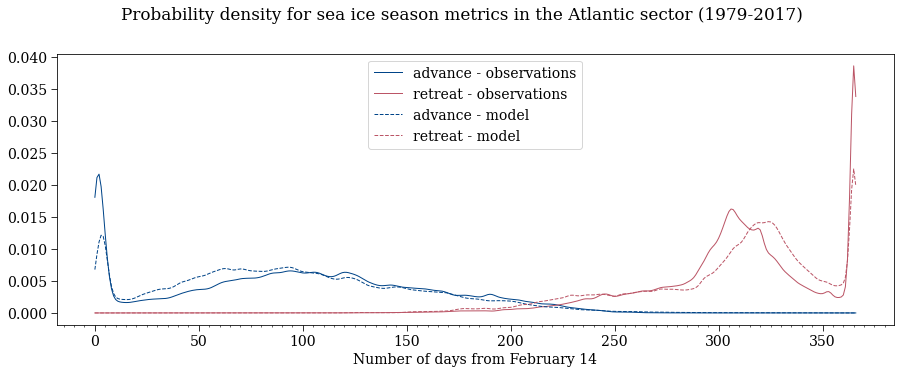

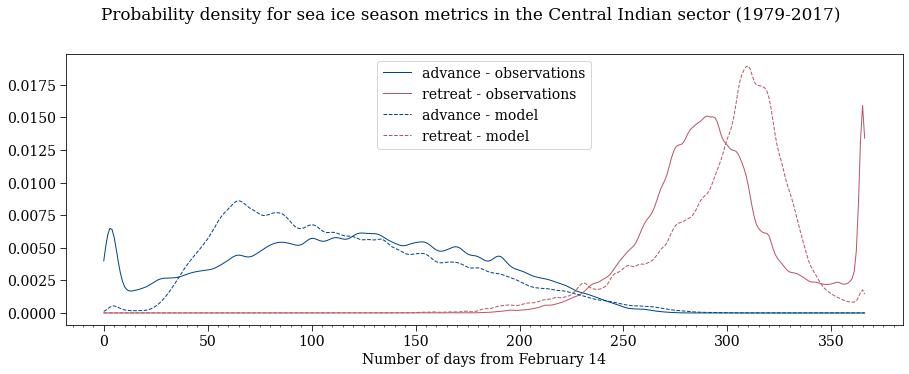

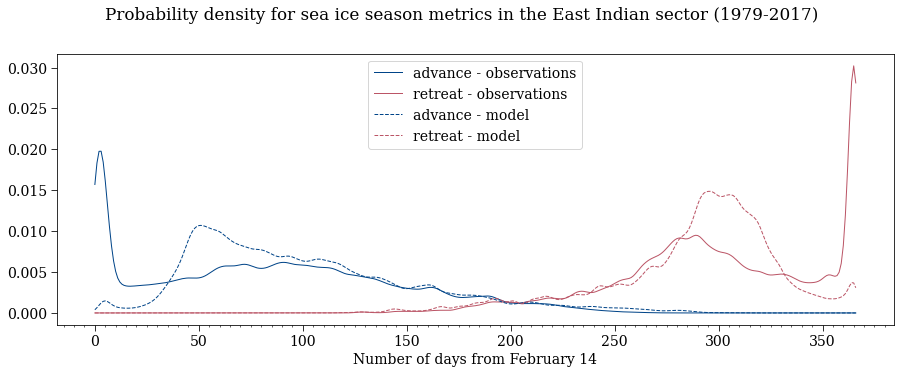

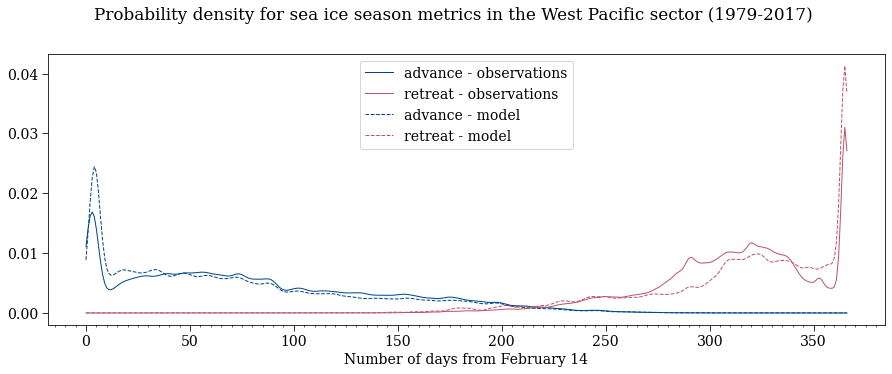

In [61]:
#Folder where figures will be saved
out_folder = r'/g/data/v45/la6889/Figures/PDFs/SIS/Weighted/'
#Apply plotting function
[plot_weightedPDF(data_pdf[f'{sec}_obs'], data_pdf[f'{sec}_mod'], bins = np.arange(0, 367), 
                  weights_obs = clipped_area[f'{sec}_obs'], weights_mod = clipped_area[f'{sec}_mod'],
                  out_folder = out_folder) for sec in sectorNames]